In [1]:
import fly_plot_lib.plot as fpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import figurefirst as fifi
from scipy import stats
import pynumdiff
import seaborn as sns
import scipy.signal
import fly_plot_lib.flymath as flymath
# from statsmodels.stats import proportions_ztest

2024-02-02 11:26:12,157 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [3]:
import seaborn as sns

In [77]:
def wrap_angle(a):
    return np.arctan2(np.sin(a), np.cos(a))


In [4]:
#Home for helper functions
def get_longer_traj(df, time_min = 1680, id_key='obj_id_unique'):
    catcher =[]
    for i in df[id_key].unique():
        d = df[df[id_key]==i]
        d = d[d['time stamp'].between(-100, 5000)]
        if d['time stamp'].max() >time_min:
            catcher.append(d)
    final_df =pd.concat(catcher)
    return final_df
        


In [5]:
def remove_discontinuities(x, y, jump=2):
    """
    Returns an array with np.nan inserted between all discontinuities (defined by the size of jump), this prevents plotting functions from plotting the connecting line, which looks ugly.
    
    x    -- numpy array (1 dim)
    y    -- numpy array with the discontinuities (1 dim)
    jump -- size of discontinuity to break
    
    """

    pos = np.where(np.abs(np.diff(y)) >= jump)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)
    
    return x, y
    

In [6]:
#helper function for slicing means with 95% CI's
def slice_means_gs(df, index, time_key='time stamp', tmin=-100, tmax = 3000,):
    time_vec=[]
    mean_vec=[]
    upper_vec =[]
    lower_vec =[]
    df=df[df[time_key].between(tmin, tmax)]
    time_vec_ =df[time_key].unique()
    time_vec_ = sorted(time_vec_)
    for i in  time_vec_:
        dummy_df =df[df[time_key]==i]
        dummy_df=dummy_df[dummy_df['ground speed'].between(0, 2.0)]
        time_vec.append(i)
        mean = dummy_df[index].mean()
        upper= dummy_df[index].mean() + dummy_df[index].sem()*1.96
        lower= dummy_df[index].mean() - dummy_df[index].sem()*1.96
        mean_vec.append(mean)
        upper_vec.append(upper)
        lower_vec.append(lower)
        #print(i)
    return time_vec, mean_vec, upper_vec, lower_vec


In [7]:
#applying centering function, not for any analyses but helps center trajectories in plots for alignment
def establish_end_as_origin(df, end_time =680, id_key = 'obj_id_unique'):
    df_catcher= []
    for i in df[id_key].unique():
        d_ =df[df['obj_id_unique']==i]
        d_=d_[d_['time stamp'].between(-5000, 5000)]
        if d_['time stamp'].max()>1680:
            try:
                ind = np.where(d_['time stamp']==680)[0][0]
                ind0 =np.where(d_['time stamp']==0)[0][0]

                x_ref =d_['x'].iloc[ind]
                y_ref = d_['y'].iloc[ind]
                d_['norm x']=d_['x']-x_ref
                d_['norm y']=d_['y']-y_ref
                df_catcher.append(d_)
            except:
                pass
    df_fin= pd.concat(df_catcher)
    return df_fin

In [8]:
def unwrap_angle(z, correction_window_for_2pi=100, n_range=2, plot=False):

        
    smooth_zs = np.array(z[0:2])
    for i in range(2, len(z)):
        first_ix = np.max([0, i-correction_window_for_2pi])
        last_ix = i

        nbase = np.round( (smooth_zs[-1] - z[i])/(2*np.pi) )

        candidates = []
        for n in range(-1*n_range, n_range):
            candidates.append(n*2*np.pi+nbase*2*np.pi+z[i])
        error = np.abs(candidates - np.mean(smooth_zs[first_ix:last_ix])) 
        smooth_zs = np.hstack(( smooth_zs, [candidates[np.argmin(error)]] ))
    if plot:
        plt.plot(smooth_zs, '.', color='black', markersize=1)
        
    return smooth_zs

# Helper function for isolating and plotting two turn sequence on course direction plots

In [49]:
#Used in final version of figure
def plot_raw_course_single_ax(head_pos_interp_g1, ax1,c_base ='gray',c1 =c1, c2=c2, direction='pos', linewidth=0.2, alpha =0.4):

    threshold = 0.004
    dt = 10
    
    #fig = plt.figure(figsize=(10,3))
    #ax1 = fig.add_subplot(121)
    #ax1.set_xlim(-500, 3000)

    #ax2 = fig.add_subplot(122)
    #ax2.set_xlim(-100, 3000)

    n_with_2_turns = 0
    n_without_2_turns = 0

    anemometric_saccade_info = {'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    anemotaxis_saccade_info = { 'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    for r in range(len(head_pos_interp_g1)):

        if direction == 'pos':
            a = unwrap_angle(head_pos_interp_g1[r] - np.pi, 5)
        else:
            a = unwrap_angle(head_pos_interp_g1[r] + np.pi, 5)
        smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,10,10])
        rawsmootha, rawda = pynumdiff.linear_model.savgoldiff(a, dt, [3,4,4]) #pynumdiff.finite_difference.first_order(a, dt)
        
        # anemometric
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
            
        last_ix = np.where(t_interp<450)[0][-1]
        first_ix = np.where(t_interp>10)[0][0]
        p = p[ (p<last_ix)*(p>first_ix)]
        if len(p)>0:
            ix_anemometric = p[0]

        if direction == 'pos':
            chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
        else:
            chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
        anemometric_saccade = None
        for chunk in chunks:
            if ix_anemometric in chunk:
                anemometric_saccade = chunk
                break

        

        # anemotaxis
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        first_ix = ix_anemometric
        last_ix = np.where(t_interp<750)[0][-1]
        p = p[ (p>first_ix)*(p<last_ix)]
        ix_anemotaxis = p[0]

        if direction == 'pos':
            chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
        else:
            chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
        anemotaxis_saccade = None
        for chunk in chunks:
            if ix_anemotaxis in chunk:
                anemotaxis_saccade = chunk
                break

        if anemotaxis_saccade is not None and anemometric_saccade is not None:
            peak = np.max( np.abs(rawda[anemometric_saccade]) )
            amplitude = (np.cumsum(rawda[anemometric_saccade])*dt)[-1]
            duration = t_interp[anemometric_saccade][-1] - t_interp[anemometric_saccade][0]
            end_point = head_pos_interp_g1[r][anemometric_saccade][-1]
            start_point = head_pos_interp_g1[r][anemometric_saccade][0]
            anemometric_saccade_info['peak_angular_velocity'].append( np.abs(peak) )
            anemometric_saccade_info['amplitude'].append(amplitude)
            anemometric_saccade_info['duration'].append(duration)
            anemometric_saccade_info['end_point'].append(end_point)
            anemometric_saccade_info['start_point'].append(start_point)
            
            peak = np.max( np.abs(rawda[anemotaxis_saccade]) )
            amplitude = (np.cumsum(rawda[anemotaxis_saccade])*dt)[-1]
            duration = t_interp[anemotaxis_saccade][-1] - t_interp[anemotaxis_saccade][0]
            end_point = head_pos_interp_g1[r][anemotaxis_saccade][-1]
            start_point = head_pos_interp_g1[r][anemotaxis_saccade][0]

            anemotaxis_saccade_info['peak_angular_velocity'].append(np.abs(peak))
            anemotaxis_saccade_info['amplitude'].append(amplitude)
            anemotaxis_saccade_info['duration'].append(duration)
            anemotaxis_saccade_info['end_point'].append(end_point)
            anemotaxis_saccade_info['start_point'].append(start_point)
        #ix_middle = int( (ix_anemotaxis - ix_anemometric)/2) + ix_anemometric
        #ax1.plot(t_interp[ixp], head_pos_interp_g1[r][ixp], '*')



        if anemometric_saccade is not None and anemotaxis_saccade is not None:
            n_with_2_turns += 1

            # before anemometric
            t_plot = t_interp[0:anemometric_saccade[0]]
            h_plot = head_pos_interp_g1[r][0:anemometric_saccade[0]]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)

            # anemometric
            t_plot = t_interp[anemometric_saccade]
            h_plot = head_pos_interp_g1[r][anemometric_saccade]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c1, linewidth = linewidth, alpha =alpha)

             # in between time
            t_plot = t_interp[anemometric_saccade[-1]:anemotaxis_saccade[0]]
            h_plot = head_pos_interp_g1[r][anemometric_saccade[-1]:anemotaxis_saccade[0]]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)

            # anemotaxis
            t_plot = t_interp[anemotaxis_saccade]
            h_plot = head_pos_interp_g1[r][anemotaxis_saccade]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c2, linewidth = linewidth, alpha =alpha)

            # after anemotaxis
            t_plot = t_interp[anemotaxis_saccade[-1]:] 
            h_plot = head_pos_interp_g1[r][anemotaxis_saccade[-1]:]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =0.5)

        else:
            #print(r)
            n_without_2_turns += 1
            x, y = remove_discontinuities(t_interp, head_pos_interp_g1[r])
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)
    #ax1.plot(t_interp, np.mean(head_pos_interp_g1, axis=0), color='red')

    #print(n_with_2_turns)
    #print(n_without_2_turns)

    return anemometric_saccade_info, anemotaxis_saccade_info, n_with_2_turns, n_without_2_turns

def mean_angle(angle, axis=0):
    return np.arctan2(np.nanmean(np.sin(angle), axis=axis), np.nanmean(np.cos(angle), axis=axis))

# Helper function for plotting isolated saccades

In [40]:

def plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax1, ax2, direction='pos', 
                                    linewidth=0.2, alpha = 0.4, c1= 'orange', c2='crimson'):

    threshold = 0.004
    dt = 10
    
    #fig = plt.figure(figsize=(10,3))
    #ax1 = fig.add_subplot(121)
    #ax1.set_xlim(-500, 3000)

    #ax2 = fig.add_subplot(122)
    #ax2.set_xlim(-100, 3000)

    n_with_2_turns = 0
    n_without_2_turns = 0

    anemometric_saccade_info = {'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    anemotaxis_saccade_info = { 'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    for r in range(len(head_pos_interp_g1)):

        if direction == 'pos':
            a = unwrap_angle(head_pos_interp_g1[r] - np.pi, 5)
        else:
            a = unwrap_angle(head_pos_interp_g1[r] + np.pi, 5)
        smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,10,10])
        rawsmootha, rawda = pynumdiff.linear_model.savgoldiff(a, dt, [3,4,4]) #pynumdiff.finite_difference.first_order(a, dt)
        
        # anemometric
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
            
        last_ix = np.where(t_interp<450)[0][-1]
        first_ix = np.where(t_interp>10)[0][0]
        p = p[ (p<last_ix)*(p>first_ix)]
        ix_anemometric = p[0]

        if direction == 'pos':
            chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
        else:
            chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
        anemometric_saccade = None
        for chunk in chunks:
            if ix_anemometric in chunk:
                anemometric_saccade = chunk
                break

        

        # anemotaxis
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        first_ix = ix_anemometric
        last_ix = np.where(t_interp<750)[0][-1]
        p = p[ (p>first_ix)*(p<last_ix)]
        ix_anemotaxis = p[0]

        if direction == 'pos':
            chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
        else:
            chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
        anemotaxis_saccade = None
        for chunk in chunks:
            if ix_anemotaxis in chunk:
                anemotaxis_saccade = chunk
                break

        if anemotaxis_saccade is not None and anemometric_saccade is not None:
            peak = np.max( np.abs(rawda[anemometric_saccade]) )
            amplitude = (np.cumsum(rawda[anemometric_saccade])*dt)[-1]
            duration = t_interp[anemometric_saccade][-1] - t_interp[anemometric_saccade][0]
            end_point = head_pos_interp_g1[r][anemometric_saccade][-1]
            start_point = head_pos_interp_g1[r][anemometric_saccade][0]

            anemometric_saccade_info['peak_angular_velocity'].append( np.abs(peak) )
            anemometric_saccade_info['amplitude'].append(amplitude)
            anemometric_saccade_info['duration'].append(duration)
            anemometric_saccade_info['end_point'].append(end_point)
            anemometric_saccade_info['start_point'].append(start_point)
            
            peak = np.max( np.abs(rawda[anemotaxis_saccade]) )
            amplitude = (np.cumsum(rawda[anemotaxis_saccade])*dt)[-1]
            duration = t_interp[anemotaxis_saccade][-1] - t_interp[anemotaxis_saccade][0]
            end_point = head_pos_interp_g1[r][anemotaxis_saccade][-1]
            start_point = head_pos_interp_g1[r][anemotaxis_saccade][0]

            anemotaxis_saccade_info['peak_angular_velocity'].append(np.abs(peak))
            anemotaxis_saccade_info['amplitude'].append(amplitude)
            anemotaxis_saccade_info['duration'].append(duration)
            anemotaxis_saccade_info['end_point'].append(end_point)
            anemotaxis_saccade_info['start_point'].append(start_point)
        #ix_middle = int( (ix_anemotaxis - ix_anemometric)/2) + ix_anemometric
        #ax1.plot(t_interp[ixp], head_pos_interp_g1[r][ixp], '*')



        if anemometric_saccade is not None and anemotaxis_saccade is not None:
            n_with_2_turns += 1

            # before anemometric
            #t_plot = t_interp[0:anemometric_saccade[0]]
            #h_plot = head_pos_interp_g1[r][0:anemometric_saccade[0]]
            #x, y = remove_discontinuities(t_plot - np.mean(t_plot), h_plot)
            #ax1.plot(x, y, color = 'pink', linewidth = linewidth, alpha =0.4)

            # anemometric
            if direction == 'pos':
                ind= np.where(rawda[anemometric_saccade]==rawda[anemometric_saccade].max())[0][0]
            else:
                ind= np.where(rawda[anemometric_saccade]==rawda[anemometric_saccade].min())[0][0]
            t_len = len(anemometric_saccade)
            #print("index is " +str(t_len))
            align_time = np.arange(-1*ind, t_len-ind, 1)
            #print(align_time)
            align_time= align_time*10.
            align_time.astype(float)
            #print(align_time)
            t_plot = t_interp[anemometric_saccade]
            #print(t_plot)
            h_plot = head_pos_interp_g1[r][anemometric_saccade]
            #print(len(h_plot))
            #x, y = remove_discontinuities(t_plot - np.mean(t_plot) + 300, h_plot)
            x, y = remove_discontinuities(t_plot-np.mean(t_plot), h_plot, jump =np.pi/2.)
            ax1.plot(x, y, color = c1, linewidth = linewidth, alpha =alpha)

            # in between time
#             t_plot = t_interp[anemometric_saccade[-1]:anemotaxis_saccade[0]]
#             h_plot = head_pos_interp_g1[r][anemometric_saccade[-1]:anemotaxis_saccade[0]]
#             x, y = remove_discontinuities(t_plot - np.mean(t_plot) + 600, h_plot)
#             ax1.plot(x, y, color = 'scarlet', linewidth = linewidth, alpha =0.4)

            # anemotaxis
            #fix direction switch
            #abs_da =np.abs(rawda[anemotaxis])
            if direction == 'pos':
                ind= np.where(rawda[anemotaxis_saccade]==rawda[anemotaxis_saccade].min())[0][0]
            else:
                ind= np.where(rawda[anemotaxis_saccade]==rawda[anemotaxis_saccade].max())[0][0]
            t_len = len(anemotaxis_saccade)
            align_time = np.arange(-1*ind, t_len-ind, 1)
            align_time= align_time*10.
            align_time.astype(float)
            t_plot = t_interp[anemotaxis_saccade]
            h_plot = head_pos_interp_g1[r][anemotaxis_saccade]
            #x, y = remove_discontinuities(t_plot - np.mean(t_plot) + 900, h_plot)
            x, y = remove_discontinuities(t_plot-np.mean(t_plot), h_plot, jump = np.pi/2)
            ax2.plot(x, y, color = c2, linewidth = linewidth, alpha =alpha, markeredgecolor = None)

#             # after anemotaxis
#             t_plot = t_interp[anemotaxis_saccade[-1]:] - t_interp[anemotaxis_saccade[-1]:][0]
#             h_plot = head_pos_interp_g1[r][anemotaxis_saccade[-1]:]
#             x, y = remove_discontinuities(t_plot + 1200, h_plot)
#             ax1.plot(x, y, color = 'pink', linewidth = linewidth, alpha =0.4)

        else:
            #print(r)
            n_without_2_turns += 1
            x, y = remove_discontinuities(t_interp, head_pos_interp_g1[r])
            #ax2.plot(x, y, color = 'lightskyblue', linewidth = linewidth, alpha =0.4)
    #ax1.plot(t_interp, np.mean(head_pos_interp_g1, axis=0), color='red')

    #print(n_with_2_turns)
    #print(n_without_2_turns)

    return anemometric_saccade_info, anemotaxis_saccade_info, n_with_2_turns, n_without_2_turns

def mean_angle(angle, axis=0):
    return np.arctan2(np.nanmean(np.sin(angle), axis=axis), np.nanmean(np.cos(angle), axis=axis))

In [12]:
#maybe used in supplement?
def plot_split_trajecs_no_wind_version_turn_align(head_pos_interp_g1, ax1, ax2, direction='pos', linewidth=0.2, c= 'purple', alpha = 0.5):
    # fig = plt.figure(figsize=(10,3))
    # ax1 = fig.add_subplot(121)
    # #ax1.set_xlim(-500, 3000)
    # ax1.set_ylim(-6.28, 6.28)

    # ax2 = fig.add_subplot(122)
    # #ax2.set_xlim(-100, 3000)
    # ax2.set_ylim(-6.28, 6.28)

    threshold = 0.004
    
    anemometric_saccade_info = {'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': []}
    
    n_with_1_turn = 0
    n_without_1_turn = 0
    
    for r in range(len(head_pos_interp_g1)):

        a = head_pos_interp_g1[r]
        smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,10,10])
        rawsmootha, rawda = pynumdiff.linear_model.savgoldiff(a, dt, [3,4,4]) #pynumdiff.finite_difference.first_order(a, dt)

        # anemometric
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(da, [4])
        else:
            p = scipy.signal.find_peaks_cwt(-1*da, [4])

        last_ix = np.where( (t_interp<600) )[0][-1]
        first_ix = np.where( (t_interp>0) )[0][0]
        p = p[ (p<last_ix)*(p>first_ix)]
        if len(p)>0:
            ix_anemometric = p[0]
        else:
            ix_anemometric = -1

        chunks = []
        if direction == 'pos':
            ix = np.where(da>threshold)[0]
            if len(ix) > 0:
                chunks, breaks = flymath.get_continuous_chunks( ix )
        else:
            ix = np.where(da<-1*threshold)[0]
            if len(ix) > 0:
                chunks, breaks = flymath.get_continuous_chunks( ix )
        anemometric_saccade = None
        for chunk in chunks:
            if ix_anemometric in chunk:
                anemometric_saccade = chunk
                break

        if anemometric_saccade is not None:
            peak = np.max( np.abs(rawda[anemometric_saccade]) )
            amplitude = (np.cumsum(rawda[anemometric_saccade])*dt)[-1]
            duration = t_interp[anemometric_saccade][-1] - t_interp[anemometric_saccade][0]
            end_point = head_pos_interp_g1[r][anemometric_saccade][-1]

            anemometric_saccade_info['peak_angular_velocity'].append( np.abs(peak) )
            anemometric_saccade_info['amplitude'].append(amplitude)
            anemometric_saccade_info['duration'].append(duration)
            anemometric_saccade_info['end_point'].append(end_point)

        if anemometric_saccade is not None:
            n_with_1_turn += 1
            
            if direction == 'pos':
                ind= np.where(np.abs(rawda[anemometric_saccade])==np.abs(rawda[anemometric_saccade]).max())[0][0]
            else:
                ind= np.where(np.abs(rawda[anemometric_saccade])==np.abs(rawda[anemometric_saccade]).max())[0][0]
            t_len = len(anemometric_saccade)
            #print("index is " +str(t_len))
            align_time = np.arange(-1*ind, t_len-ind, 1)
            #print(align_time)
            align_time= align_time*10.
            align_time.astype(float)
            # before anemometric
#             t_plot = t_interp[0:anemometric_saccade[0]]
#             h_plot = head_pos_interp_g1[r][0:anemometric_saccade[0]]
#             x, y = remove_discontinuities(t_plot - np.mean(t_plot), h_plot)
#             ax1.plot(x, y, color = 'pink', linewidth = linewidth, alpha =0.4)

            # anemometric
            t_plot = t_interp[anemometric_saccade]
            h_plot = head_pos_interp_g1[r][anemometric_saccade]
            x, y = remove_discontinuities(t_plot-np.mean(t_plot), h_plot)
            ax1.plot(x, y, color = c, linewidth = linewidth, alpha =alpha, markeredgecolor=None)

            # after anemotaxis
#             t_plot = t_interp[anemometric_saccade[-1]:]
#             t_plot = t_plot - t_plot[0] + 600
#             #print(anemometric_saccade[-1])
#             #t_plot -= t_plot[0]
#             h_plot = head_pos_interp_g1[r][anemometric_saccade[-1]:]
#             x, y = remove_discontinuities(t_plot, h_plot)
#             ax1.plot(x, y, color = 'pink', linewidth = linewidth, alpha =0.4)

        else:
            print(r)
            n_without_1_turn += 1
            x, y = remove_discontinuities(t_interp, head_pos_interp_g1[r])
            #ax2.plot(x, y, color = 'lightskyblue', linewidth = linewidth, alpha =0.4)
    #ax1.plot(t_interp, np.mean(head_pos_interp_g1, axis=0), color='red')

    return anemometric_saccade_info, n_with_1_turn, n_without_1_turn

# Load in data sets

In [9]:
####Load in data sets
orco=pd.read_csv('../trimmed_data/main/OrcoCsChrimson_laminar_wind_merged.csv')
nw = pd.read_csv('../trimmed_data/main/Orco_CsChrimson_still_air_merged.csv')

In [11]:
####Some basic calcs and trimming
nw=nw[nw['time stamp'].between(-5000, 5000)]
nw['ground speed']=(nw['xvel']**2+nw['yvel']**2)**0.5

orco['ground speed']=(orco['xvel']**2+orco['yvel']**2)**0.5
orco=orco[orco['time stamp'].between(-5000, 5000)]

2024-01-29 16:00:14,552 [INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-01-29 16:00:14,554 [INFO] NumExpr defaulting to 8 threads.


In [12]:
#get trajectories with at least one full second after stimulus end
nw=get_longer_traj(nw)
orco=get_longer_traj(orco)

In [13]:
#Manual trajectory inspection found these to be bogies (dead fly on bottom or roof that has an altitude error and sends it through trigger zone)
nw_remove_vec =['7887_20220813_165621', '16132_20220813_165621', '17547_20220813_165621', '18884_20220813_165621', '24498_20220813_165621'
            ,'24498_20220813_165621' '48280_20220813_16562', '51293_20220813_165621', '52041_20220813_165621', '59859_20220813_165621',
             '3422_20220814_165127', '11784_20220814_165127', '26952_20220814_165127', '33917_20220814_165127', '2057_20220815_162329',
             '2258_20220815_162329', '3752_20220815_162329', '6963_20220815_162329', '14331_20220815_162329', '16448_20220815_162329', '19357_20220815_162329',
             '22286_20220815_162329', '24581_20220815_162329', '34034_20220815_162329', '44894_20220815_162329', '9897_20220817_173045'
             ,'22348_20220817_173045', '22515_20220817_173045']
nw=nw[nw['obj_id_unique'].isin(nw_remove_vec)==False]

In [14]:
#separate into flash and sham
lw100=orco[orco['duration']==100]
lw0=orco[orco['duration']==0]
nw100=nw[nw['duration']==100]
nw0=nw[nw['duration']==0]

# Split laminar wind by a flies orientation at the time of their stimulus

In [15]:
#split laminar wind into upwind cw and dw data sets
lw100['abs ang vel']=np.abs(lw100['theta dot smooth'])
cw=[]
uw=[]
dw=[]
for i in lw100['obj_id_unique'].unique():
    d =lw100[lw100['obj_id_unique']==i]
    ind=np.where(d['time stamp']==0)[0][0]
    o=np.abs(d['heading'].iloc[ind])
    #print(o)
    if o<=np.pi/4:
        uw.append(i)
    if o> np.pi/4 and o <=(3.*np.pi/4):
        cw.append(i)
    elif o >(3.*np.pi/4):
        dw.append(i)


#Subslice the laminar wind data set        
cw_orco=lw100[lw100['obj_id_unique'].isin(cw)]
uw_orco=lw100[lw100['obj_id_unique'].isin(uw)]
dw_orco=lw100[lw100['obj_id_unique'].isin(dw)]


/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
#Example crosswind trajectories for figure
cw_add_ons =['202_20220926_173927','6303_20220926_173927', '6312_20220926_173927', '8101_20220926_173927'
            ]

In [22]:
nw100['abs ang vel']=np.abs(nw100['theta dot smooth'])

/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
no_wind_test_traj =['2743_20220813_165621', '5098_20220813_165621', '5911_20220813_165621',  '16906_20220813_165621','467_20220814_165127', '791_20220814_165127'
                   ,'4720_20220814_165127','11977_20220814_165127' ]

In [20]:
#Standardize a couple size and color things so figures all come out the same
ms=4
lw=.25
fs=6
linew=.5
tl=3

#Color scheme here
#set one
# c1='#ff4475'
# c2 = '#2a52be'
# cnw='#854abb'

# #set two
# c1='#ff6361'
# c2='#003f5c'
# cnw='#bc5090'

#set three
# c1='#fbb36a'
# c2='#488f31'
# cnw='#de425b'

#Set four
c1='blue'
cnw = '#007ba7'
c2='purple'

In [18]:
#upwind candidate ID's
#Id's of examplar trajectories, 5 fit in figure 12439 is best shape for the annotatoed parts
t_vec =['12439_20220926_173927', '530_20220927_170437',  '4864_20220927_170437',  '2983_20220927_170437']

In [17]:
template = '../figure_first_templates/f6.svg'

# Trajectories Block

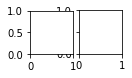

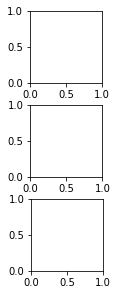

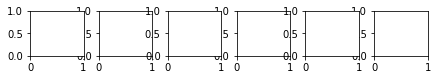

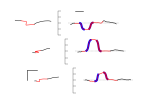

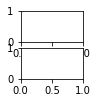

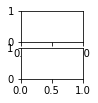

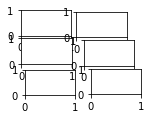

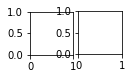

In [21]:
layout =fifi.svg_to_axes.FigureLayout(template, autogenlayers=True, make_mplfigures=True, hide_layers=[])
#First Trajectory
ax=layout.axes[('traj', 't1')]
traj =lw100[lw100['obj_id_unique']==t_vec[0]]
traj=establish_end_as_origin(traj)
traj=traj[traj['time stamp'].between(-100, 1000)]
sub=traj[traj['time stamp'].between(300, 600)]

#Trajectory 1 traj plot
pre =traj[traj['time stamp']<=0]
dur = traj[traj['time stamp'].between(0, 680)]
post =traj[traj['time stamp'] >=680]
ax.plot(pre['norm x'], pre['norm y'], color ='k', linewidth = lw+.2)
ax.plot(dur['norm x'], dur['norm y'], color = 'red', linewidth = lw+.2)
ax.plot(post['norm x'], post['norm y'], color = 'k', linewidth = lw+.2)
ax.set_xlim(-.2, .2)
ax.set_ylim(-.1, .1)

# ax.scatter(traj['norm x'].iloc[0],traj['norm y'].iloc[0], marker = (3, 0, 120),s=ms, color ='k')
# #ax.scatter(traj['norm x'].iloc[35],traj['norm y'].iloc[35], marker = (3, 0, 65),s=ms, color ='r')
# ax.scatter(traj['norm x'].iloc[-1],traj['norm y'].iloc[-1], marker = (3, 0, 120),s=ms, color ='k')

ax.set_xticklabels([])
#ax.set_rasterization_zorder(1000)


#Trajectory 1 Heading plot
axh1=layout.axes[('traj', 'h1')]
#turn shading
axh1.plot(dur['time stamp'].iloc[13:23], dur['heading'].iloc[13:23], color = c1, linewidth = lw+1.75, alpha = 1) 
axh1.plot(dur['time stamp'].iloc[35:44], dur['heading'].iloc[35:44], color = c2, linewidth = lw+1.75, alpha = 1)
#rest
axh1.plot(pre['time stamp'], pre['heading'], color ='k', linewidth = lw+.25)
axh1.plot(dur['time stamp'], dur['heading'], color = 'red', linewidth = lw+.25 )
axh1.plot(post['time stamp'], post['heading'], color = 'k', linewidth = lw+.25)
# axh1.axvline(x=175, color = c1, linewidth =0.5, linestyle = '--')
# axh1.axvline(x=380, color = c2, linewidth =0.5, linestyle = '--')
axh1.plot([0,200], [3.14,3.14], color = 'k', linewidth =0.5)
axh1.axhline(y=0, color = 'k', linestyle = "--", alpha = 0.5, linewidth = lw)
axh1.set_yticklabels(['',' ',' ', ' ', ' '])


#Trajectory 2 traj plot
axt2=layout.axes[('traj', 't2')]

traj =lw100[lw100['obj_id_unique']==t_vec[3]]
traj=establish_end_as_origin(traj)
traj=traj[traj['time stamp'].between(-100, 1000)]

sub=traj[traj['time stamp'].between(300, 600)]
pre =traj[traj['time stamp']<=0]
dur = traj[traj['time stamp'].between(0, 680)]
post =traj[traj['time stamp'] >=680]

axt2.plot(pre['norm x'], pre['norm y'], color ='k', linewidth = lw+.2)
axt2.plot(dur['norm x'], dur['norm y'], color = 'red', linewidth = lw+.2)
axt2.plot(post['norm x'], post['norm y'], color = 'k', linewidth = lw+.2)
axt2.set_xlim(-.25, .25)
axt2.set_ylim(-.125, .125)

# axt2.scatter(traj['norm x'].iloc[0],traj['norm y'].iloc[0], marker = (3, 0, 135),s=ms, color ='k')
# #axt2.scatter(traj['norm x'].iloc[68],traj['norm y'].iloc[68], marker = (3, 0, 158),s=ms, color ='r')
# axt2.scatter(traj['norm x'].iloc[-1],traj['norm y'].iloc[-1], marker = (3, 0, 20),s=ms, color ='k')

axt2.set_xticklabels([])
#axt2.set_rasterization_zorder(1000)


#Trajectory 2 heading plot
axh2=layout.axes[('traj', 'h2')]

axh2.plot(dur['time stamp'].iloc[15:23], dur['heading'].iloc[15:23], color = c1, linewidth = lw+1.75, alpha = 1) 
axh2.plot(dur['time stamp'].iloc[36:45], dur['heading'].iloc[36:45], color = c2, linewidth = lw+1.75, alpha = 1)

axh2.plot(pre['time stamp'], pre['heading'], color ='k', linewidth = lw+.25)
axh2.plot(dur['time stamp'], dur['heading'], color = 'red', linewidth = lw+.25 )
axh2.plot(post['time stamp'], post['heading'], color = 'k', linewidth = lw+.25)

axh2.axhline(y=0, color = 'k', linestyle = "--", alpha = 0.5, linewidth = lw)
# axh2.axvline(x=200, color = c1, linewidth =0.5, linestyle = '--')
# axh2.axvline(x=405, color = c2, linewidth =0.5, linestyle = '--')

axh2.set_yticklabels(['',' ',' ', ' ', ' '])


#Trajectory 3 trajectory plot
axt3=layout.axes[('traj', 't3')]
traj =lw100[lw100['obj_id_unique']==t_vec[2]]
traj=establish_end_as_origin(traj)
traj=traj[traj['time stamp'].between(-100, 1000)]

sub=traj[traj['time stamp'].between(300, 600)]
pre =traj[traj['time stamp']<=0]
dur = traj[traj['time stamp'].between(0, 680)]
post =traj[traj['time stamp'] >=680]

axt3.plot(pre['norm x'], pre['norm y'], color ='k', linewidth = lw+.2)
axt3.plot(dur['norm x'], dur['norm y'], color = 'red', linewidth = lw+.2)
axt3.plot(post['norm x'], post['norm y'], color = 'k', linewidth = lw+.2)

axt2.plot([-.20,-.1], [.09, .09], color = 'k', linewidth = .5)
axt2.plot([-.2, -.2],[.09, -.01], color = 'k', linewidth=0.5)

axt3.set_xlim(-.25, .25)
axt3.set_ylim(-.125, .125)

# axt3.scatter(traj['norm x'].iloc[0],traj['norm y'].iloc[0], marker = (3, 0, 35),s=ms, color ='k')
# #axt3.scatter(traj['norm x'].iloc[60],traj['norm y'].iloc[60], marker = (3, 0, 30),s=ms, color ='r')
# axt3.scatter(traj['norm x'].iloc[-1],traj['norm y'].iloc[-1], marker = (3, 0, 120),s=ms, color ='k')


ax.set_xticklabels([])
#ax.set_rasterization_zorder(1000)

#trajectory 3 heading plot
axh3=layout.axes[('traj', 'h3')]

axh3.plot(dur['time stamp'].iloc[11:22], dur['heading'].iloc[11:22], color = c1, linewidth = lw+1.75, alpha = 1) 
axh3.plot(dur['time stamp'].iloc[36:46], dur['heading'].iloc[36:46], color = c2, linewidth = lw+1.75, alpha = 1)

axh3.plot(pre['time stamp'], pre['heading'], color ='k', linewidth = lw+.25)
axh3.plot(dur['time stamp'], dur['heading'], color = 'red', linewidth = lw +.25)
axh3.plot(post['time stamp'], post['heading'], color = 'k', linewidth = lw+.25)

axh3.axhline(y=0, color = 'k', linestyle = "--", alpha = 0.5, linewidth = lw)
# axh3.axvline(x=210, color = c1, linewidth =0.5, linestyle = '--')
# axh3.axvline(x=420, color = c2, linewidth =0.5, linestyle = '--')

axh3.set_yticklabels(['',' ',' ', ' ', ' '])


fifi.mpl_functions.adjust_spines(axh2, ['left'], xticks =[], yticks=[-1*np.pi,-1*0.5*np.pi,  0, np.pi*0.5, 3.14], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(axt2, [], xticks =[], yticks=[])
fifi.mpl_functions.adjust_spines(axh1, ['left'], xticks =[], yticks=[-1*np.pi,-1*0.5*np.pi,  0, np.pi*0.5, 3.14], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax, [], xticks =[], yticks=[])
fifi.mpl_functions.adjust_spines(axh2, ['left'], xticks =[], yticks=[-1*np.pi,-1*0.5*np.pi,  0, np.pi*0.5, 3.14], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(axt2, [], xticks =[], yticks=[])
fifi.mpl_functions.adjust_spines(axh3, ['left'], xticks =[], yticks=[-1*np.pi,-1*0.5*np.pi,  0, np.pi*0.5, 3.14], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(axt3, [], xticks =[], yticks=[])

layout.append_figure_to_layer(layout.figures['traj'], 'traj', cleartarget=True)
layout.write_svg(template)

# Crosswind at Stimulus trajectories

In [22]:
cw_vec=['600_20220929_174113', '202_20220926_173927', '6312_20220926_173927' ]

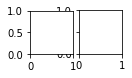

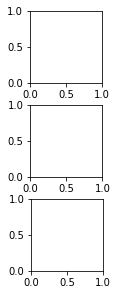

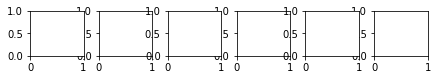

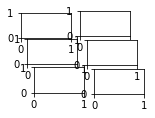

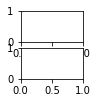

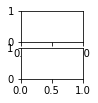

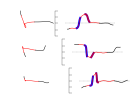

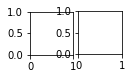

In [23]:
layout =fifi.svg_to_axes.FigureLayout(template, autogenlayers=True, make_mplfigures=True, hide_layers=[])
#First Trajectory
ax=layout.axes[('cwtraj', 't1')]
traj =lw100[lw100['obj_id_unique']==cw_vec[0]]
traj=establish_end_as_origin(traj)
traj=traj[traj['time stamp'].between(-60, 1000)]
sub=traj[traj['time stamp'].between(300, 600)]

#Trajectory 1 traj plot
pre =traj[traj['time stamp']<=0]
dur = traj[traj['time stamp'].between(0, 680)]
post =traj[traj['time stamp'] >=680]
ax.plot(pre['norm x'], pre['norm y'], color ='k', linewidth = lw+.2)
ax.plot(dur['norm x'], dur['norm y'], color = 'red', linewidth = lw+.2)
ax.plot(post['norm x'], post['norm y'], color = 'k', linewidth = lw+.2)
ax.set_xlim(-.2, .2)
ax.set_ylim(-.1, .1)
# ax.scatter(traj['norm x'].iloc[2],traj['norm y'].iloc[0], marker = (3, 0, 68),s=ms, color ='k')
# #ax.scatter(traj['norm x'].iloc[35],traj['norm y'].iloc[35], marker = (3, 0, 65),s=ms, color ='r')
# ax.scatter(traj['norm x'].iloc[-1],traj['norm y'].iloc[-1], marker = (3, 0, 120),s=ms, color ='k')

ax.set_xticklabels([])
#ax.set_rasterization_zorder(1000)


#Trajectory 1 Heading plot
axh1=layout.axes[('cwtraj', 'h1')]
#turn shading
axh1.plot(dur['time stamp'].iloc[16:25], dur['heading'].iloc[16:25], color = c1, linewidth = lw+1.75, alpha = 1) 
axh1.plot(dur['time stamp'].iloc[36:46], dur['heading'].iloc[36:46], color = c2, linewidth = lw+1.75, alpha = 1)
#rest
axh1.plot(pre['time stamp'], pre['heading'], color ='k', linewidth = lw+.25)
axh1.plot(dur['time stamp'], dur['heading'], color = 'red', linewidth = lw+.25 )
axh1.plot(post['time stamp'], post['heading'], color = 'k', linewidth = lw+.25)
# axh1.axvline(x=175, color = c1, linewidth =0.5, linestyle = '--')
# axh1.axvline(x=380, color = c2, linewidth =0.5, linestyle = '--')

axh1.axhline(y=0, color = 'k', linestyle = "--", alpha = 0.5, linewidth = lw)
axh1.set_yticklabels(['',' ',' ', ' ', ' '])


#Trajectory 2 traj plot
axt2=layout.axes[('cwtraj', 't2')]

traj =lw100[lw100['obj_id_unique']==cw_vec[1]]
traj=establish_end_as_origin(traj)
traj=traj[traj['time stamp'].between(-100, 1000)]

sub=traj[traj['time stamp'].between(300, 600)]
pre =traj[traj['time stamp']<=0]
dur = traj[traj['time stamp'].between(0, 680)]
post =traj[traj['time stamp'] >=680]

axt2.plot(pre['norm x'], pre['norm y'], color ='k', linewidth = lw+.2)
axt2.plot(dur['norm x'], dur['norm y'], color = 'red', linewidth = lw+.2)
axt2.plot(post['norm x'], post['norm y'], color = 'k', linewidth = lw+.2)
axt2.set_xlim(-.25, .25)
axt2.set_ylim(-.125, .125)

# axt2.scatter(traj['norm x'].iloc[0],traj['norm y'].iloc[0], marker = (3, 0, 135),s=ms, color ='k')
# #axt2.scatter(traj['norm x'].iloc[68],traj['norm y'].iloc[68], marker = (3, 0, 158),s=ms, color ='r')
# axt2.scatter(traj['norm x'].iloc[-1],traj['norm y'].iloc[-1], marker = (3, 0, 20),s=ms, color ='k')

axt2.set_xticklabels([])
#axt2.set_rasterization_zorder(1000)


#Trajectory 2 heading plot
axh2=layout.axes[('cwtraj', 'h2')]

axh2.plot(dur['time stamp'].iloc[15:21], dur['heading'].iloc[15:21], color = c1, linewidth = lw+1.75, alpha = 1) 
axh2.plot(dur['time stamp'].iloc[30:37], dur['heading'].iloc[30:37], color = c2, linewidth = lw+1.75, alpha = 1)

axh2.plot(pre['time stamp'], pre['heading'], color ='k', linewidth = lw+.25)
axh2.plot(dur['time stamp'], dur['heading'], color = 'red', linewidth = lw+.25 )
axh2.plot(post['time stamp'], post['heading'], color = 'k', linewidth = lw+.25)

axh2.axhline(y=0, color = 'k', linestyle = "--", alpha = 0.5, linewidth = lw)
# axh2.axvline(x=200, color = c1, linewidth =0.5, linestyle = '--')
# axh2.axvline(x=405, color = c2, linewidth =0.5, linestyle = '--')

axh2.set_yticklabels(['',' ',' ', ' ', ' '])


#Trajectory 3 trajectory plot
axt3=layout.axes[('cwtraj', 't3')]
traj =lw100[lw100['obj_id_unique']==cw_vec[2]]
traj=establish_end_as_origin(traj)
traj=traj[traj['time stamp'].between(-100, 1000)]

sub=traj[traj['time stamp'].between(300, 600)]
pre =traj[traj['time stamp']<=0]
dur = traj[traj['time stamp'].between(0, 680)]
post =traj[traj['time stamp'] >=680]

axt3.plot(pre['norm x'], pre['norm y'], color ='k', linewidth = lw+.2)
axt3.plot(dur['norm x'], dur['norm y'], color = 'red', linewidth = lw+.2)
axt3.plot(post['norm x'], post['norm y'], color = 'k', linewidth = lw+.2)

axt3.set_xlim(-.25, .25)
axt3.set_ylim(-.125, .125)

# axt3.scatter(traj['norm x'].iloc[0],traj['norm y'].iloc[0], marker = (3, 0, 50),s=ms, color ='k')
# #axt3.scatter(traj['norm x'].iloc[60],traj['norm y'].iloc[60], marker = (3, 0, 30),s=ms, color ='r')
# axt3.scatter(traj['norm x'].iloc[-1],traj['norm y'].iloc[-1], marker = (3, 0, 120),s=ms, color ='k')


ax.set_xticklabels([])
#ax.set_rasterization_zorder(1000)

#trajectory 3 heading plot
axh3=layout.axes[('cwtraj', 'h3')]

axh3.plot(dur['time stamp'].iloc[11:18], dur['heading'].iloc[11:18], color = c1, linewidth = lw+1.75, alpha = 1) 
axh3.plot(dur['time stamp'].iloc[25:30], dur['heading'].iloc[25:30], color = c2, linewidth = lw+1.75, alpha = 1)

axh3.plot(pre['time stamp'], pre['heading'], color ='k', linewidth = lw+.25)
axh3.plot(dur['time stamp'], dur['heading'], color = 'red', linewidth = lw +.25)
axh3.plot(post['time stamp'], post['heading'], color = 'k', linewidth = lw+.25)

axh3.axhline(y=0, color = 'k', linestyle = "--", alpha = 0.5, linewidth = lw)
# axh3.axvline(x=210, color = c1, linewidth =0.5, linestyle = '--')
# axh3.axvline(x=420, color = c2, linewidth =0.5, linestyle = '--')

axh3.set_yticklabels(['',' ',' ', ' ', ' '])


fifi.mpl_functions.adjust_spines(axh2, ['left'], xticks =[], yticks=[-1*np.pi,-1*0.5*np.pi,  0, np.pi*0.5, 3.14], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(axt2, [], xticks =[], yticks=[])
fifi.mpl_functions.adjust_spines(axh1, ['left'], xticks =[], yticks=[-1*np.pi,-1*0.5*np.pi,  0, np.pi*0.5, 3.14], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax, [], xticks =[], yticks=[])
fifi.mpl_functions.adjust_spines(axh2, ['left'], xticks =[], yticks=[-1*np.pi,-1*0.5*np.pi,  0, np.pi*0.5, 3.14], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(axt2, [], xticks =[], yticks=[])
fifi.mpl_functions.adjust_spines(axh3, ['left'], xticks =[], yticks=[-1*np.pi,-1*0.5*np.pi,  0, np.pi*0.5, 3.14], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(axt3, [], xticks =[], yticks=[])

layout.append_figure_to_layer(layout.figures['cwtraj'], 'cwtraj', cleartarget=True)
layout.write_svg(template)

In [24]:
#Smoothing function for mean angular velocity and ground speed plots
def filter_testing(traj, head_key='heading', filter_params =[1, 2, 8], dt=.01 ):
    head_vec = traj[head_key].to_numpy()
    head_vec = np.unwrap(head_vec)
    traj=traj[traj['time stamp'].between(-100, 5000)]
    traj['head unwrap']=head_vec
    traj['raw angvel']=traj['head unwrap'].diff()/dt
    traj['raw angvel']=np.abs(traj['raw angvel'])
    raw_angvel= np.abs(np.diff(head_vec)/dt)
    smootha, da =pynumdiff.linear_model.savgoldiff(head_vec, dt, filter_params)
    np.insert(da, [0], np.nan)
    filter_param_tag =""
    for i in filter_params:
        filter_param_tag+=str(i)
    traj['smoothed_angvel_params_'+filter_param_tag]=np.abs(da)
    return traj

In [25]:
#Applies smoothing to every unique trajectory in the data set
def filter_angvel_whole_data_set(df, filter_params=[1, 2, 8], dt=.01, id_key='obj_id_unique', head_key='heading'):
    collector =[]
    c=0
    for i in df[id_key].unique():
        if c%5==0:
            print("trajectory "+str(c)+ ' out of '+str(len(df[id_key].unique())))
        c+=1
        d =df[df[id_key]==i]
        d=d[d['time stamp'].between(-100, 5000)]
        d= filter_testing(d, head_key=head_key, filter_params=filter_params, dt=dt)
        collector.append(d)
    fin=pd.concat(collector)
    return fin

In [26]:
# Separating out upwind, crosswind and downwind Orco
#split laminar wind into upwind cw and dw data sets
#and adding angular velocity filter

cw=[]
uw=[]
dw=[]
for i in lw100['obj_id_unique'].unique():
    d =lw100[lw100['obj_id_unique']==i]
    ind=np.where(d['time stamp']==0)[0][0]
    o=np.abs(d['heading'].iloc[ind])
    #print(o)
    if o<=np.pi/4:
        uw.append(i)
    if o> np.pi/4 and o <=(3.*np.pi/4):
        cw.append(i)
    elif o >(3.*np.pi/4):
        dw.append(i)


#Subslice the laminar wind data set        
cw_orco=lw100[lw100['obj_id_unique'].isin(cw)]
uw_orco=lw100[lw100['obj_id_unique'].isin(uw)]
dw_orco=lw100[lw100['obj_id_unique'].isin(dw)]

cw_orco=filter_angvel_whole_data_set(cw_orco)
uw_orco= filter_angvel_whole_data_set(uw_orco)
dw_orco=filter_angvel_whole_data_set(dw_orco)

trajectory 0 out of 83
trajectory 5 out of 83
trajectory 10 out of 83
trajectory 15 out of 83
trajectory 20 out of 83
trajectory 25 out of 83
trajectory 30 out of 83
trajectory 35 out of 83
trajectory 40 out of 83
trajectory 45 out of 83
trajectory 50 out of 83
trajectory 55 out of 83
trajectory 60 out of 83
trajectory 65 out of 83
trajectory 70 out of 83
trajectory 75 out of 83
trajectory 80 out of 83
trajectory 0 out of 123
trajectory 5 out of 123
trajectory 10 out of 123
trajectory 15 out of 123
trajectory 20 out of 123
trajectory 25 out of 123
trajectory 30 out of 123
trajectory 35 out of 123
trajectory 40 out of 123
trajectory 45 out of 123
trajectory 50 out of 123
trajectory 55 out of 123
trajectory 60 out of 123
trajectory 65 out of 123
trajectory 70 out of 123
trajectory 75 out of 123
trajectory 80 out of 123
trajectory 85 out of 123
trajectory 90 out of 123
trajectory 95 out of 123
trajectory 100 out of 123
trajectory 105 out of 123
trajectory 110 out of 123
trajectory 115 out

In [28]:
#Read in and apply same trajecoty inclusion for wild type controls
wt=pd.read_csv('../trimmed_data/main/wild_type_laminar_merged.csv')
wt=wt[wt['time stamp'].between(-100, 5000)]
wt['ground speed']=(wt['xvel']**2+wt['yvel']**2)**.5
wt100=wt[wt['duration']==100]
holder_vec =[]
#longer trajectories only
for i in wt100['obj_id_unique'].unique():
    d =wt100[wt100['obj_id_unique']==i]
    if d['time stamp'].max()>1680:
        holder_vec.append(d)
wt100=pd.concat(holder_vec)

In [29]:
#split wild type data into similar, upwind, crosswind, and downwind data sets
#Then apply same smoothing function
cw=[]
uw=[]
dw=[]
for i in wt100['obj_id_unique'].unique():
    d =wt100[wt100['obj_id_unique']==i]
    ind=np.where(d['time stamp']==0)[0][0]
    o=np.abs(d['heading'].iloc[ind])
    #print(o)
    if o<=np.pi/4:
        uw.append(i)
    if o> np.pi/4 and o <=(3.*np.pi/4):
        cw.append(i)
    elif o >(3.*np.pi/4):
        dw.append(i)


#Subslice the laminar wind data set        
cw_wt=wt100[wt100['obj_id_unique'].isin(cw)]
uw_wt=wt100[wt100['obj_id_unique'].isin(uw)]
dw_wt=wt100[wt100['obj_id_unique'].isin(dw)]

cw_wt =filter_angvel_whole_data_set(cw_wt)
uw_wt=filter_angvel_whole_data_set(uw_wt)
dw_wt =filter_angvel_whole_data_set(dw_wt)

trajectory 0 out of 113
trajectory 5 out of 113
trajectory 10 out of 113
trajectory 15 out of 113
trajectory 20 out of 113
trajectory 25 out of 113
trajectory 30 out of 113
trajectory 35 out of 113
trajectory 40 out of 113
trajectory 45 out of 113
trajectory 50 out of 113
trajectory 55 out of 113
trajectory 60 out of 113
trajectory 65 out of 113
trajectory 70 out of 113
trajectory 75 out of 113
trajectory 80 out of 113
trajectory 85 out of 113
trajectory 90 out of 113
trajectory 95 out of 113
trajectory 100 out of 113
trajectory 105 out of 113
trajectory 110 out of 113
trajectory 0 out of 229
trajectory 5 out of 229
trajectory 10 out of 229
trajectory 15 out of 229
trajectory 20 out of 229
trajectory 25 out of 229
trajectory 30 out of 229
trajectory 35 out of 229
trajectory 40 out of 229
trajectory 45 out of 229
trajectory 50 out of 229
trajectory 55 out of 229
trajectory 60 out of 229
trajectory 65 out of 229
trajectory 70 out of 229
trajectory 75 out of 229
trajectory 80 out of 229
t

In [34]:
nw100=filter_angvel_whole_data_set(nw100)

trajectory 0 out of 275
trajectory 5 out of 275
trajectory 10 out of 275
trajectory 15 out of 275
trajectory 20 out of 275
trajectory 25 out of 275
trajectory 30 out of 275
trajectory 35 out of 275
trajectory 40 out of 275
trajectory 45 out of 275
trajectory 50 out of 275
trajectory 55 out of 275
trajectory 60 out of 275
trajectory 65 out of 275
trajectory 70 out of 275
trajectory 75 out of 275
trajectory 80 out of 275
trajectory 85 out of 275
trajectory 90 out of 275
trajectory 95 out of 275
trajectory 100 out of 275
trajectory 105 out of 275
trajectory 110 out of 275
trajectory 115 out of 275
trajectory 120 out of 275
trajectory 125 out of 275
trajectory 130 out of 275
trajectory 135 out of 275
trajectory 140 out of 275
trajectory 145 out of 275
trajectory 150 out of 275
trajectory 155 out of 275
trajectory 160 out of 275
trajectory 165 out of 275
trajectory 170 out of 275
trajectory 175 out of 275
trajectory 180 out of 275
trajectory 185 out of 275
trajectory 190 out of 275
trajecto

In [31]:
wt_nw = pd.read_csv('../trimmed_data/main/wildtype_still_air_merged.csv')
wt_nw100= wt_nw[wt_nw['duration']==100]
wt_nw100=filter_angvel_whole_data_set(wt_nw100)

trajectory 0 out of 187
trajectory 5 out of 187
trajectory 10 out of 187
trajectory 15 out of 187
trajectory 20 out of 187
trajectory 25 out of 187
trajectory 30 out of 187
trajectory 35 out of 187
trajectory 40 out of 187
trajectory 45 out of 187
trajectory 50 out of 187
trajectory 55 out of 187
trajectory 60 out of 187
trajectory 65 out of 187
trajectory 70 out of 187
trajectory 75 out of 187
trajectory 80 out of 187
trajectory 85 out of 187
trajectory 90 out of 187
trajectory 95 out of 187
trajectory 100 out of 187
trajectory 105 out of 187
trajectory 110 out of 187
trajectory 115 out of 187
trajectory 120 out of 187
trajectory 125 out of 187
trajectory 130 out of 187
trajectory 135 out of 187
trajectory 140 out of 187
trajectory 145 out of 187
trajectory 150 out of 187
trajectory 155 out of 187
trajectory 160 out of 187
trajectory 165 out of 187
trajectory 170 out of 187
trajectory 175 out of 187
trajectory 180 out of 187
trajectory 185 out of 187


In [32]:
wt_nw100['ground speed']=(wt_nw100['xvel']**2+wt_nw100['yvel']**2)**0.5

# ground speed and angular velocity plot section

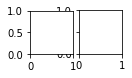

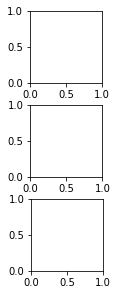

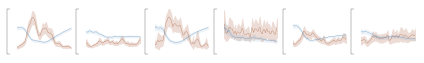

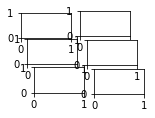

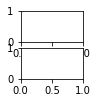

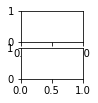

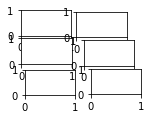

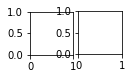

In [35]:
####Setting up fifi layout
layout =fifi.svg_to_axes.FigureLayout(template, autogenlayers=True, make_mplfigures=True, hide_layers=[])
#print(layout.axes)

#Generating axes and corresponding twin ax to plot both curves at the same time
ax =layout.axes[('gs_ang', 'uw_orco')]
ax_=ax.twinx()
ax1=layout.axes[('gs_ang', 'uw_wt')]
ax1_=ax1.twinx()
ax2=layout.axes[('gs_ang', 'cw_orco')]
ax2_=ax2.twinx()
ax3=layout.axes[('gs_ang', 'cw_wt')]
ax3_=ax3.twinx()
ax4=layout.axes[('gs_ang', 'nw_orco')]
ax4_=ax4.twinx()
ax5=layout.axes[('gs_ang', 'nw_wt')]
ax5_=ax5.twinx()

#####Generate mean population angular veloctiy and ground speed for upwind set, decided savgold filter params [1,2,8]
t, m, u, l = slice_means_gs(uw_orco, 'smoothed_angvel_params_128')
tgs, mgs, ugs, lgs =slice_means_gs(uw_orco, 'ground speed')

ax.plot(t, m, linewidth = lw, color = 'sienna')
ax.fill_between(t, u, l, color = 'sienna', alpha = 0.2, label = '', linewidth =0)
ax.set_xlim(0, 680)
ax.set_ylim(0, 16)
ax_.set_ylim(0, .6)
ax.set_yticklabels([])
ax_.set_yticklabels([])
ax_.plot(tgs, mgs, color = 'steelblue', linewidth =lw)
ax_.fill_between(tgs, ugs, lgs, color ='steelblue', alpha = 0.1, linewidth =0)

######################################################################################################
# upwind_wt
uw_wt['smoothed_angvel_params_128']=np.abs(uw_wt['smoothed_angvel_params_128'])
t, m, u, l = slice_means_gs(uw_wt, 'smoothed_angvel_params_128')
tgs, mgs, ugs, lgs =slice_means_gs(uw_wt, 'ground speed')

ax1.plot(t, m, linewidth = lw, color = 'sienna')
ax1.fill_between(t, u, l, color = 'sienna', alpha = 0.2, label = '', linewidth =0)
ax1.set_xlim(0, 680)
ax1.set_ylim(0, 16)
ax1.set_yticklabels([])
ax1_.set_yticklabels([])
ax1_.set_ylim(0, .6)
ax1_.plot(tgs, mgs, color = 'steelblue', linewidth =lw)
ax1_.fill_between(tgs, ugs, lgs, color ='steelblue', alpha = 0.1, linewidth =0)


######################################################################################################
#Crosswind subset

cw_orco['smoothed_angvel_params_128']=np.abs(cw_orco['smoothed_angvel_params_128'])
t, m, u, l = slice_means_gs(cw_orco, 'smoothed_angvel_params_128')
tgs, mgs, ugs, lgs =slice_means_gs(cw_orco, 'ground speed')

ax2.plot(t, m, linewidth = lw, color = 'sienna')
ax2.fill_between(t, u, l, color = 'sienna', alpha = 0.2, label = '', linewidth =0)
ax2.set_xlim(0, 680)
ax2.set_ylim(0, 16)
ax2_.set_ylim(0, .6)
ax2.set_yticklabels([])
ax2_.set_yticklabels([])
ax2_.set_ylim()
ax2_.plot(tgs, mgs, color = 'steelblue', linewidth =lw)
ax2_.fill_between(tgs, ugs, lgs, color ='steelblue', alpha = 0.1, linewidth =0)

######################################################################################################
# cwpwt
cw_wt['smoothed_angvel_params_128']=np.abs(cw_wt['smoothed_angvel_params_128'])
t, m, u, l = slice_means_gs(cw_wt, 'smoothed_angvel_params_128')
tgs, mgs, ugs, lgs =slice_means_gs(cw_wt, 'ground speed')

ax3.plot(t, m, linewidth = lw, color = 'sienna')
ax3.fill_between(t, u, l, color = 'sienna', alpha = 0.2, label = '', linewidth =0)
ax3.set_xlim(0, 680)
ax3.set_ylim(0, 16)
ax3.set_yticklabels([])
ax3_.set_yticklabels([])
ax3_.set_ylim(0, .6)
ax3_.plot(tgs, mgs, color = 'steelblue', linewidth =lw)
ax3_.fill_between(tgs, ugs, lgs, color ='steelblue', alpha = 0.1, linewidth =0)
###########################################
#nw orco
nw100['smoothed_angvel_params_128']=np.abs(nw100['smoothed_angvel_params_128'])
t, m, u, l = slice_means_gs(nw100, 'smoothed_angvel_params_128')
tgs, mgs, ugs, lgs =slice_means_gs(nw100, 'ground speed')

ax4.plot(t, m, linewidth = lw, color = 'sienna')
ax4.fill_between(t, u, l, color = 'sienna', alpha = 0.2, label = '', linewidth =0)
ax4.set_xlim(0, 680)
ax4.set_ylim(0, 16)
ax4.set_yticklabels([])
ax4_.set_yticklabels([])
ax4_.set_ylim(0, .6)
ax4_.plot(tgs, mgs, color = 'steelblue', linewidth =lw)
ax4_.fill_between(tgs, ugs, lgs, color ='steelblue', alpha = 0.1, linewidth =0)
###########################################
#nw wt
wt_nw100['smoothed_angvel_params_128']=np.abs(wt_nw100['smoothed_angvel_params_128'])
t, m, u, l = slice_means_gs(wt_nw100, 'smoothed_angvel_params_128')
tgs, mgs, ugs, lgs =slice_means_gs(wt_nw100, 'ground speed')

ax5.plot(t, m, linewidth = lw, color = 'sienna')
ax5.fill_between(t, u, l, color = 'sienna', alpha = 0.2, label = '', linewidth =0)
ax5.set_xlim(0, 680)
ax5.set_ylim(0, 16)
ax5.set_yticklabels([])
ax5_.set_yticklabels([])
ax5_.set_ylim(0, .6)
ax5_.plot(tgs, mgs, color = 'steelblue', linewidth =lw)
ax5_.fill_between(tgs, ugs, lgs, color ='steelblue', alpha = 0.1, linewidth =0)
######################
fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=[], yticks=[0, 18], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax_, [], xticks=[], yticks=[], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=[0, 18], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax1_, [], xticks=[], yticks=[], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax2, ['left'], xticks=[], yticks=[0, 18], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax2_, [], xticks=[], yticks=[], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax3, ['left'], xticks=[], yticks=[0, 18], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax3_, [], xticks=[], yticks=[], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax4, ['left'], xticks=[], yticks=[0, 18], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax4_, [], xticks=[], yticks=[], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax5, ['left'], xticks=[], yticks=[0, 18], tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax5_, [], xticks=[], yticks=[], tick_length=3, linewidth=lw)



layout.append_figure_to_layer(layout.figures['gs_ang'], 'gs_ang', cleartarget=True)
layout.write_svg(template)   

# Upwind Flies Raw Trajectories where turns are shaded +Isolated Turns


In [36]:
#Used in final version of figure
def plot_raw_course_single_ax(head_pos_interp_g1, ax1,c_base ='gray',c1 =c1, c2=c2, direction='pos', linewidth=0.2, alpha =0.4):

    threshold = 0.004
    dt = 10
    
    #fig = plt.figure(figsize=(10,3))
    #ax1 = fig.add_subplot(121)
    #ax1.set_xlim(-500, 3000)

    #ax2 = fig.add_subplot(122)
    #ax2.set_xlim(-100, 3000)

    n_with_2_turns = 0
    n_without_2_turns = 0

    anemometric_saccade_info = {'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    anemotaxis_saccade_info = { 'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    for r in range(len(head_pos_interp_g1)):

        if direction == 'pos':
            a = unwrap_angle(head_pos_interp_g1[r] - np.pi, 5)
        else:
            a = unwrap_angle(head_pos_interp_g1[r] + np.pi, 5)
        smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,10,10])
        rawsmootha, rawda = pynumdiff.linear_model.savgoldiff(a, dt, [3,4,4]) #pynumdiff.finite_difference.first_order(a, dt)
        
        # anemometric
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
            
        last_ix = np.where(t_interp<450)[0][-1]
        first_ix = np.where(t_interp>10)[0][0]
        p = p[ (p<last_ix)*(p>first_ix)]
        if len(p)>0:
            ix_anemometric = p[0]

        if direction == 'pos':
            chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
        else:
            chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
        anemometric_saccade = None
        for chunk in chunks:
            if ix_anemometric in chunk:
                anemometric_saccade = chunk
                break

        

        # anemotaxis
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        first_ix = ix_anemometric
        last_ix = np.where(t_interp<750)[0][-1]
        p = p[ (p>first_ix)*(p<last_ix)]
        ix_anemotaxis = p[0]

        if direction == 'pos':
            chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
        else:
            chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
        anemotaxis_saccade = None
        for chunk in chunks:
            if ix_anemotaxis in chunk:
                anemotaxis_saccade = chunk
                break

        if anemotaxis_saccade is not None and anemometric_saccade is not None:
            peak = np.max( np.abs(rawda[anemometric_saccade]) )
            amplitude = (np.cumsum(rawda[anemometric_saccade])*dt)[-1]
            duration = t_interp[anemometric_saccade][-1] - t_interp[anemometric_saccade][0]
            end_point = head_pos_interp_g1[r][anemometric_saccade][-1]
            start_point = head_pos_interp_g1[r][anemometric_saccade][0]
            anemometric_saccade_info['peak_angular_velocity'].append( np.abs(peak) )
            anemometric_saccade_info['amplitude'].append(amplitude)
            anemometric_saccade_info['duration'].append(duration)
            anemometric_saccade_info['end_point'].append(end_point)
            anemometric_saccade_info['start_point'].append(start_point)
            
            peak = np.max( np.abs(rawda[anemotaxis_saccade]) )
            amplitude = (np.cumsum(rawda[anemotaxis_saccade])*dt)[-1]
            duration = t_interp[anemotaxis_saccade][-1] - t_interp[anemotaxis_saccade][0]
            end_point = head_pos_interp_g1[r][anemotaxis_saccade][-1]
            start_point = head_pos_interp_g1[r][anemotaxis_saccade][0]

            anemotaxis_saccade_info['peak_angular_velocity'].append(np.abs(peak))
            anemotaxis_saccade_info['amplitude'].append(amplitude)
            anemotaxis_saccade_info['duration'].append(duration)
            anemotaxis_saccade_info['end_point'].append(end_point)
            anemotaxis_saccade_info['start_point'].append(start_point)
        #ix_middle = int( (ix_anemotaxis - ix_anemometric)/2) + ix_anemometric
        #ax1.plot(t_interp[ixp], head_pos_interp_g1[r][ixp], '*')



        if anemometric_saccade is not None and anemotaxis_saccade is not None:
            n_with_2_turns += 1

            # before anemometric
            t_plot = t_interp[0:anemometric_saccade[0]]
            h_plot = head_pos_interp_g1[r][0:anemometric_saccade[0]]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)

            # anemometric
            t_plot = t_interp[anemometric_saccade]
            h_plot = head_pos_interp_g1[r][anemometric_saccade]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c1, linewidth = linewidth, alpha =alpha)

             # in between time
            t_plot = t_interp[anemometric_saccade[-1]:anemotaxis_saccade[0]]
            h_plot = head_pos_interp_g1[r][anemometric_saccade[-1]:anemotaxis_saccade[0]]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)

            # anemotaxis
            t_plot = t_interp[anemotaxis_saccade]
            h_plot = head_pos_interp_g1[r][anemotaxis_saccade]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c2, linewidth = linewidth, alpha =alpha)

            # after anemotaxis
            t_plot = t_interp[anemotaxis_saccade[-1]:] 
            h_plot = head_pos_interp_g1[r][anemotaxis_saccade[-1]:]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =0.5)

        else:
            #print(r)
            n_without_2_turns += 1
            x, y = remove_discontinuities(t_interp, head_pos_interp_g1[r])
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)
    #ax1.plot(t_interp, np.mean(head_pos_interp_g1, axis=0), color='red')

    #print(n_with_2_turns)
    #print(n_without_2_turns)

    return anemometric_saccade_info, anemotaxis_saccade_info, n_with_2_turns, n_without_2_turns

def mean_angle(angle, axis=0):
    return np.arctan2(np.nanmean(np.sin(angle), axis=axis), np.nanmean(np.cos(angle), axis=axis))

Function is starting with 123
First data pruning step
After first step there are 123 trajectories in tact
N trajecs in raw panel pos:  66
N trajecs in raw panel neg:  57
data structure of head_interp_groups is
10
data structure of head_interp_groups is
9
mean and std of anemometric saccade duration
114.8936170212766
40.52172206678268

mean and std of anemotaxis saccade duration
119.7872340425532
44.60175369618342
Final count with two turns in negative group is 38
Final count with two turns in positive group is 47
Final count without two turns in negative group is 10
Final count without two turns in positive group is 9
function is ending with 104 trajectories


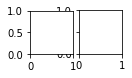

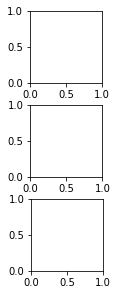

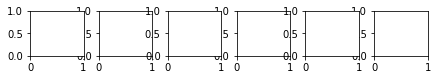

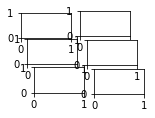

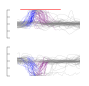

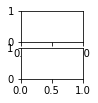

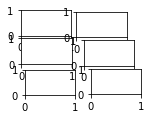

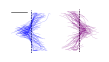

In [41]:
#Flies turning towards positive or negative direction
#10 ms between frames
dt=.01
#Return to these cells to print out relevant information for reporting
head_pos = []
time_pos = []

head_neg = []
time_neg = []
######################################################


pos_tt_count =0
neg_tt_count =0

for i in uw_orco['obj_id_unique'].unique():

    c=uw_orco[uw_orco['obj_id_unique']==i]
    time_vec = c['time stamp'].values
    head_vec= c['heading'].values

    initial_head = np.median( head_vec[(time_vec>-50)*(time_vec<0)] )
    sign = np.sign( initial_head )
    #head_vec *= sign
    #initial_head *= sign
    
    # signed ang vel
    a = unwrap_angle(c['heading'].values, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>-50)*(time_vec<3000) )
    ix_da = np.where( (time_vec>50)*(time_vec<200) )[0]
    if np.mean(da[ix_da]) > 0:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] < 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(h_flipped[ix_plot])
        time_pos.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
#         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
    else:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] > 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
                    
        head_neg.append(h_flipped[ix_plot])
        time_neg.append(time_vec[ix_plot])
)

        
#######################################################################################
t_interp = np.arange(-50, 3000, 10)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    head_neg_interp.append(head_interp)
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )
#print("After first step there are " +str(len(head_neg_interp)+len(head_pos_interp))+ " trajectories in tact")


########################################################################################
# group 1 -- flies deviate more than the difference between heading and upwind
head_pos_interp_g1 = []
head_pos_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_pos_interp.shape[0]):
    h = head_pos_interp[r,:]
    if np.max(h[ix]) > (h[0]+0.3925): # <<<< arbitrary
        head_pos_interp_g1.append(h)
    else:
        head_pos_interp_g0.append(h)
        
head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

# group 1 -- flies deviate more than the difference between heading and upwind
head_neg_interp_g1 = []
head_neg_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_neg_interp.shape[0]):
    h = head_neg_interp[r,:]
    if np.min(h[ix]) < h[0]-0.3925: # <<<< arbitrary
        head_neg_interp_g1.append(h)
    else:
        head_neg_interp_g0.append(h)
        
head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
head_neg_interp_g0 = np.vstack(head_neg_interp_g0)

###########################################################################################
t_interp = t_interp.astype(float)
###########################################################################################

#Setting up the upwind axexs for raw plots
layout =fifi.svg_to_axes.FigureLayout(template, autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax=layout.axes[('lw_r', 'pos')]
ax1= layout.axes[('lw_r', 'neg')]

#Isolated Turns Axes
ax2 =layout.axes[('uw_tt', 'pos')]
ax3 =layout.axes[('uw_tt', 'neg')]
ax2.plot([-125, -25], [3.3, 3.3], color = 'k', linewidth =.5)



############################################################################################
yticks = [-3.14, -1.57, 0, 1.57, 3.14]

ax.set_yticklabels([])

ax.set_xlim(-50, 1000)
ax.set_ylim(-3.4, 3.4)
ax.plot([0, 675], [3.3, 3.3], color = 'red', linewidth = .5)
xticks = [0, 675, 1000]

r = plot_raw_course_single_ax(head_pos_interp_g1, ax,  linewidth=.2, alpha = 0.5,c1=c1, c2 =c2)
anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns_uw_pos, n_without_2_turns_uw_pos = r

r2 = plot_raw_course_single_ax(head_neg_interp_g1, ax1, linewidth=.2,alpha = 0.5, direction=None, c1=c1, c2=c2)
anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns_uw_neg, n_without_2_turns_uw_neg = r2

#Plot centered isolated turns
r3 = plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax2, ax3, linewidth=.2, alpha = 0.5,c1=c1, c2 =c2)

r4 = plot_split_trajecs_turn_aligner(head_neg_interp_g1, ax2, ax3, linewidth=.2,alpha = 0.5, direction=None, c1=c1, c2=c2)

anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns, n_without_2_turns = r
anemometric_saccade_info_uwneg, anemotaxis_saccade_info_uwneg, n_with_2_turns, n_without_2_turns = r2

ax.set_xlim(-50, 1000)
ax1.set_xlim(-50, 1000)
ax1.set_ylim(-3.4, 3.4)
ax1.set_yticklabels([])
xticks = [0, 675, 1000]

fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax2, [], xticks=[], yticks=yticks)
fifi.mpl_functions.adjust_spines(ax3, [], xticks=[], yticks=yticks)
fifi.mpl_functions.adjust_spines(ax4, [], xticks=[], yticks=yticks)
fifi.mpl_functions.adjust_spines(ax5, [], xticks=[], yticks=yticks)

xticks = [0, 675, 1000]


ax2.axvline(x=0, color = 'k', linestyle ='--', linewidth = .5, alpha =1)
ax2.axvline(x=0, color = c1, linestyle ='--', linewidth =.5, alpha = 0.5)
ax3.axvline(x=0, color = 'k', linestyle ='--', linewidth = .5, alpha =1)
ax3.axvline(x=0, color = c2, linestyle ='--', linewidth =.5, alpha = 0.5)


#####################################################################################################
#Plotting leftover trajectories
for r in range(len(head_neg_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

for r in range(len(head_pos_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

fifi.mpl_functions.set_fontsize(ax, fs)

layout.append_figure_to_layer(layout.figures['uw_tt'], 'uw_tt', cleartarget=True)
#layout.append_figure_to_layer(layout.figures['uw_ant'], 'uw_ant', cleartarget=True)
layout.append_figure_to_layer(layout.figures['lw_r'], 'lw_r', cleartarget=True)
layout.write_svg(template)

print('mean and std of anemometric saccade duration')
print( np.mean(anemometric_saccade_info_uwpos['duration']) )
print( np.std(anemometric_saccade_info_uwpos['duration']) )

print()

print('mean and std of anemotaxis saccade duration')
print( np.mean(anemotaxis_saccade_info_uwpos['duration']) )
print( np.std(anemotaxis_saccade_info_uwpos['duration']) )
#
print("Final count with two turns in negative group is "+ str(n_with_2_turns_uw_neg))
print("Final count with two turns in positive group is "+ str(n_with_2_turns_uw_pos))
print("Final count without two turns in negative group is "+ str(n_without_2_turns_uw_neg))
print("Final count without two turns in positive group is "+ str(n_without_2_turns_uw_pos))
print("function is ending with " + str(n_with_2_turns_uw_neg+n_with_2_turns_uw_pos+n_without_2_turns_uw_neg
                                     +n_without_2_turns_uw_pos) + " trajectories")

# Crosswind flies at stimulus, new style of raw trajectory plots and isolated turns


26
8
34
15
N trajecs in raw panel:  34
Two Turn Seqs detected = 46


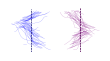

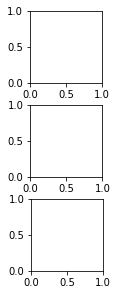

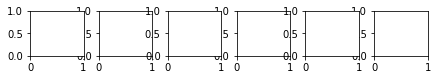

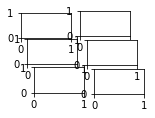

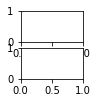

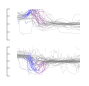

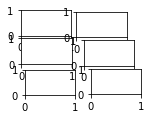

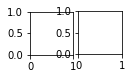

In [42]:
head_pos = []
time_pos = []

head_neg = []
time_neg = []

#########################################
for i in cw_orco['obj_id_unique'].unique():

    c=cw_orco[cw_orco['obj_id_unique']==i]
    time_vec = c['time stamp'].values
    head_vec= c['heading'].values

    initial_head = np.median( head_vec[(time_vec>-50)*(time_vec<0)] )
    sign = np.sign( initial_head )
    head_vec *= sign
    initial_head *= sign
    
    # signed ang vel
    a = unwrap_angle(c['heading'].values, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>-50)*(time_vec<3000) )
    ix_da = np.where( (time_vec>50)*(time_vec<200) )[0]
    if np.mean(da[ix_da]) > 0:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] < 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(h_flipped[ix_plot])
        time_pos.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
#         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
    else:
        head_neg.append(head_vec[ix_plot])
        time_neg.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, head_vec, jump=np.pi/2)
#         ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)

####################################################################################################
t_interp = np.arange(-50, 3000, 10)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    head_neg_interp.append(head_interp)
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )
# group 1 -- flies deviate more than the difference between heading and upwind
head_pos_interp_g1 = []
head_pos_interp_g0 = []

ix = np.where(t_interp < 500)

for r in range(head_pos_interp.shape[0]):
    h = head_pos_interp[r,:]
    if np.max(h[ix]) > (1.57+0.3925): # <<<< arbitrary
        head_pos_interp_g1.append(h)
    else:
        head_pos_interp_g0.append(h)
        
head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

print(len(head_pos_interp_g1))
print(len(head_pos_interp_g0))
# group 1 -- flies deviate more than the difference between heading and upwind
head_neg_interp_g1 = []
head_neg_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_neg_interp.shape[0]):
    h = head_neg_interp[r,:]
    if np.min(h[ix]) < -0.3925: # <<<< arbitrary
        head_neg_interp_g1.append(h)
    else:
        head_neg_interp_g0.append(h)
        
head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
head_neg_interp_g0 = np.vstack(head_neg_interp_g0)

print(len(head_neg_interp_g1))
print(len(head_neg_interp_g0))

##################################################################################
t_interp = t_interp.astype(float)
##################################################################################
layout =fifi.svg_to_axes.FigureLayout(template, autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax=layout.axes[('cw_r', 'pos')]
ax1= layout.axes[('cw_r', 'neg')]

ax2 =layout.axes['cwspag', 'cw_tt']
ax3 =layout.axes['cwspag', 'cw_nt']
##################################################################################
yticks = [-3.14, -1.57, 0, 1.57, 3.14]

ax.set_yticklabels([])
ax.set_xlim(-50, 1000)


ax.set_xlim(-50, 1000)
ax.set_ylim(-3.14, 3.14)
xticks = [0, 675, 1000]

ax1.set_xlim(-50, 1000)

fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)


# plot the broken and leftover trajectories

r = plot_raw_course_single_ax(head_pos_interp_g1, ax, c1=c1, c2=c2, alpha = 0.5)
r2 = plot_raw_course_single_ax(head_neg_interp_g1, ax1, alpha = 0.5, direction=None, c1=c1, c2= c2)

r3 = plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax2, ax3, c1=c1, c2=c2, alpha = 0.5)
r4 = plot_split_trajecs_turn_aligner(head_neg_interp_g1, ax2, ax3, alpha = 0.5, direction=None, c1=c1, c2= c2)


anemometric_saccade_info_cwpos, anemotaxis_saccade_info_cwpos, n_with_2_turns_cw_pos, n_without_2_turns = r
anemometric_saccade_info_cwneg, anemotaxis_saccade_info_cwneg, n_with_2_turns_cw_neg, n_without_2_turns = r2

for r in range(len(head_neg_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

for r in range(len(head_pos_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)


ax2.axvline(x=0, color = 'k', linestyle ='--', linewidth = .5, alpha =1)
ax2.axvline(x=0, color = c1, linestyle ='--', linewidth =.5, alpha = 0.5)
ax3.axvline(x=0, color = 'k', linestyle ='--', linewidth = .5, alpha =1)
ax3.axvline(x=0, color = c2, linestyle = "--", linewidth =0.5)

ax1.set_ylim(-3.4, 3.4)
ax1.set_yticklabels([])
xticks = [0, 675, 1000]

fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=yticks, linewidth = lw, tick_length=3 )
fifi.mpl_functions.adjust_spines(ax2, [], xticks=[], yticks=yticks)
fifi.mpl_functions.adjust_spines(ax3, [], xticks=[], yticks=yticks)


print("Two Turn Seqs detected = " + str(n_with_2_turns_cw_neg+n_with_2_turns_cw_pos))
fifi.mpl_functions.set_fontsize(ax, fs)


layout.append_figure_to_layer(layout.figures['cw_r'], 'cw_r', cleartarget=True)
layout.append_figure_to_layer(layout.figures['cwspag'], 'cwspag', cleartarget=True)
layout.write_svg(template)
#layout.append_figure_to_layer(layout.figures['upwind_pos'], 'upwind_pos', cleartarget=True)
#layout.write_svg('anemo_metric_taxis.svg')


# No wind fly subset up to date plotting functions

In [6828]:
#No wind modified trajectory plotter, modified to only detect saccades that would otherwise meet "anemometric"
#standards.  No "anemotactic" saccade required to also include
def plot_raw_trajecs_single_axis_no_wind(head_pos_interp_g1, ax1,  direction='pos', linewidth=0.2, cnw= cnw,cbase='gray', alpha = 0.5):
    threshold = 0.004
    
    anemometric_saccade_info = {'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': []}
    
    n_with_1_turn = 0
    n_without_1_turn = 0
    
    for r in range(len(head_pos_interp_g1)):

        a = head_pos_interp_g1[r]
        smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,10,10])
        rawsmootha, rawda = pynumdiff.linear_model.savgoldiff(a, dt, [3,4,4]) #pynumdiff.finite_difference.first_order(a, dt)

        # anemometric
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(da, [4])
        else:
            p = scipy.signal.find_peaks_cwt(-1*da, [4])

        last_ix = np.where( (t_interp<600) )[0][-1]
        first_ix = np.where( (t_interp>0) )[0][0]
        p = p[ (p<last_ix)*(p>first_ix)]
        if len(p)>0:
            ix_anemometric = p[0]
        else:
            ix_anemometric = -1

        chunks = []
        if direction == 'pos':
            ix = np.where(da>threshold)[0]
            if len(ix) > 0:
                chunks, breaks = flymath.get_continuous_chunks( ix )
        else:
            ix = np.where(da<-1*threshold)[0]
            if len(ix) > 0:
                chunks, breaks = flymath.get_continuous_chunks( ix )
        anemometric_saccade = None
        for chunk in chunks:
            if ix_anemometric in chunk:
                anemometric_saccade = chunk
                break

        if anemometric_saccade is not None:
            peak = np.max( np.abs(rawda[anemometric_saccade]) )
            amplitude = (np.cumsum(rawda[anemometric_saccade])*dt)[-1]
            duration = t_interp[anemometric_saccade][-1] - t_interp[anemometric_saccade][0]
            end_point = head_pos_interp_g1[r][anemometric_saccade][-1]

            anemometric_saccade_info['peak_angular_velocity'].append( np.abs(peak) )
            anemometric_saccade_info['amplitude'].append(amplitude)
            anemometric_saccade_info['duration'].append(duration)
            anemometric_saccade_info['end_point'].append(end_point)

        if anemometric_saccade is not None:
            n_with_1_turn += 1
            
            if direction == 'pos':
                ind= np.where(np.abs(rawda[anemometric_saccade])==np.abs(rawda[anemometric_saccade]).max())[0][0]
            else:
                ind= np.where(np.abs(rawda[anemometric_saccade])==np.abs(rawda[anemometric_saccade]).max())[0][0]
            t_len = len(anemometric_saccade)
            #print("index is " +str(t_len))
#             align_time = np.arange(-1*ind, t_len-ind, 1)
#             #print(align_time)
#             align_time= align_time*10.
#             align_time.astype(float)
            #before anemometric
            t_plot = t_interp[0:anemometric_saccade[0]]
            h_plot = head_pos_interp_g1[r][0:anemometric_saccade[0]]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = cbase, linewidth = linewidth, alpha =0.4)

            # anemometric
            t_plot = t_interp[anemometric_saccade]
            h_plot = head_pos_interp_g1[r][anemometric_saccade]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = cnw, linewidth = linewidth, alpha =alpha, markeredgecolor=None)

            # after anemotaxis
            t_plot = t_interp[anemometric_saccade[-1]:]
            #print(anemometric_saccade[-1])
            #t_plot -= t_plot[0]
            h_plot = head_pos_interp_g1[r][anemometric_saccade[-1]:]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = cbase, linewidth = linewidth, alpha =0.4)

        else:
            print(r)
            n_without_1_turn += 1
            x, y = remove_discontinuities(t_interp, head_pos_interp_g1[r])
            ax1.plot(x, y, color = cbase, linewidth = linewidth, alpha =0.4)
    #ax1.plot(t_interp, np.mean(head_pos_interp_g1, axis=0), color='red')

    return anemometric_saccade_info, n_with_1_turn, n_without_1_turn

# Saccade Kinematics Section

In [43]:
#compound saccade data calculated from earlier plots
#nw_saccades =[anemometric_saccade_info_nwneg, anemometric_saccade_info_nwpos]: moved to supplement

anemometric_saccades = [anemometric_saccade_info_cwpos,
                        anemometric_saccade_info_cwneg,
                        anemometric_saccade_info_uwpos,
                        anemometric_saccade_info_uwneg]

anemotaxis_saccades = [anemotaxis_saccade_info_cwpos,
                        anemotaxis_saccade_info_cwneg,
                        anemotaxis_saccade_info_uwpos,
                        anemotaxis_saccade_info_uwneg]


In [46]:
#Collecting some saccade info to make dist plot more easily and basic linear regression params
#quick linear regression to test relationship

#start vectory
start_v =[]
#magnitude vector
mag_v =[]

for anemometric_saccade in anemometric_saccades:
    start_v.append(np.abs(anemometric_saccade['start_point']))
    mag_v.append(np.abs(anemometric_saccade['amplitude']))

start =[]
mag =[]
for i in start_v:
    for j in i:
        start.append(j)
    
for i in mag_v:
    for j in i:
        mag.append(j) 

# mag_v_nw =[]
# for nw_saccade in nw_saccades:
#     mag_v_nw.append(np.abs(nw_saccade['amplitude'])) 
 
# mag_nw =[]    
# for i in mag_v_nw:
#     for j in i:
#         mag_nw.append(j)
#print(mag_nw)
m =stats.linregress(start, mag)
print(m)
    

LinregressResult(slope=-0.5078081021734923, intercept=2.5831014275735393, rvalue=-0.33366373498373164, pvalue=9.837297945282864e-05, stderr=0.1263181218719898)


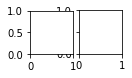

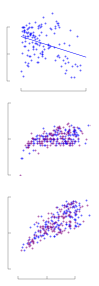

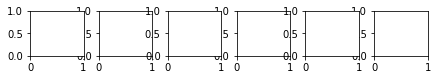

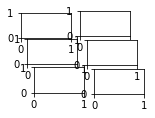

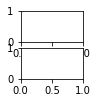

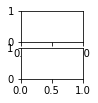

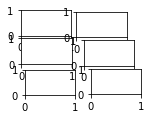

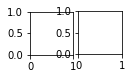

In [48]:
####Headings distribution subplot
layout =fifi.svg_to_axes.FigureLayout(template, autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax =layout.axes[('kin', 'ori')]
# ax1 =layout.axes[('dist', 'stim')]
#ax2 =layout.axes[('dist', 'metric')]
ax4 =layout.axes[('kin', 'peak')]
ax5 =layout.axes[('kin', 'dur')]



ax.set_yticklabels([])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], xticks=[0, 3*np.pi/4], yticks=[0 ,np.pi/2, 3.14], tick_length=3, linewidth=lw)
ax.set_xticklabels([])
##########################################################################################################################
#Anemometric saccade amplitude as a function of course direction
for anemometric_saccade in anemometric_saccades:
    ax.scatter(  np.abs(anemometric_saccade['start_point']), 
              np.abs(anemometric_saccade['amplitude']),
              color=c1, s=3.5, alpha =0.6, linewidth =0)
#regression params: slope=-0.5078081021734923, intercept=2.5831014275735393
t=np.linspace(0, 3.*3.14/4., 100)
reg = -.507*t+2.583
ax.plot(t, reg, color = c1, linewidth = lw*2)

###################################################################################################################
#Distribution plot of saccade magnitudes between the two cases
# sns.distplot(mag, ax=ax1, color=c1, hist=False, vertical =True)
# sns.distplot(mag_nw,ax=ax1,  color=cnw, hist=False, vertical =True)
# ax1.set_ylim(0, 5)
# #ax2.set_ylim(0, 3.14)
# ax1.set_yticklabels([])
# fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=[0 , 3.14], tick_length=3, linewidth=lw)
#fifi.mpl_functions.adjust_spines(ax2, [], xticks=[], yticks=[], tick_length=3, linewidth=lw)
##################################################################################################################################
#Peak Angular Velocity plots


for anemometric_saccade in anemometric_saccades:
    ax4.scatter(  np.abs(anemometric_saccade['amplitude'])*180/np.pi, 
              np.abs(anemometric_saccade['peak_angular_velocity'])*1000*180/np.pi,
              color=c1, s=3.5, alpha =0.6, linewidth =0)
    
for anemotaxis_saccade in anemotaxis_saccades:
    ax4.scatter(  np.abs(anemotaxis_saccade['amplitude'])*180/np.pi, 
              np.abs(anemotaxis_saccade['peak_angular_velocity'])*1000*180/np.pi,
              color=c2,s=3.5, alpha = 0.6, linewidth =0)
# for sac in nw_saccades:
#     ax4.scatter(np.abs(sac['amplitude'])*180/np.pi, 
#               np.abs(sac['peak_angular_velocity'])*1000*180/np.pi,
#               color=cnw, s=3.5, alpha = 0.6, linewidth =0)
    

ax4.set_yscale('log')
ax4.minorticks_off()
ax4.set_ylim(100, 10000)
ax4.set_xlim(0, 230)

ax4.set_yticklabels([])
ax4.set_xticklabels([])

xticks = [0, 90, 180]
yticks = [100, 1000, 10000]
fifi.mpl_functions.adjust_spines(ax4, ['left', 'bottom'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)
#################################################################################
for anemometric_saccade in anemometric_saccades:
    ax5.scatter(  np.abs(anemometric_saccade['amplitude'])*180/np.pi,
              np.abs(anemometric_saccade['duration']), color=c1, s=3.5, alpha = 0.6, linewidth=0)
    
for anemotaxis_saccade in anemotaxis_saccades:
    ax5.scatter(  np.abs(anemotaxis_saccade['amplitude'])*180/np.pi, 
              np.abs(anemotaxis_saccade['duration']),marker='o', color=c2, s=3.5, alpha = 0.6, linewidth =0)
# for sac in nw_saccades:
#     ax5.scatter(  np.abs(sac['amplitude'])*180/np.pi, 
#               np.abs(sac['duration']),color=cnw, s=3.5,marker ='o', alpha = 0.6, linewidth =0)
    
ax5.set_yscale('log')
ax5.minorticks_off()
ax5.set_ylim(10, 1000)
ax5.set_xlim(0, 230)
xticks = [0, 90, 180]
yticks = [10, 100, 1000]
ax5.set_yticklabels([])
ax5.set_xticklabels([])
fifi.mpl_functions.adjust_spines(ax5, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)


layout.append_figure_to_layer(layout.figures['kin'], 'kin', cleartarget=True)
layout.append_figure_to_layer(layout.figures['kin'], 'kin', cleartarget=True)
#layout.append_figure_to_layer(layout.figures['dist'], 'dist', cleartarget=True)
layout.write_svg(template)   


# Start supplemental figure section

In [50]:
s8_template='../figure_first_templates/s8.svg'

# Orco Responses from main fig for easier visualization: Upwind Subset

Function is starting with 123
First data pruning step
After first step there are 123 trajectories in tact
N trajecs in raw panel pos:  66
N trajecs in raw panel neg:  57
data structure of head_interp_groups is
10
data structure of head_interp_groups is
9


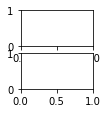

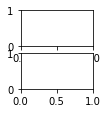

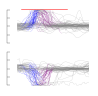

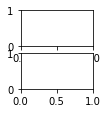

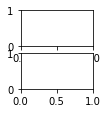

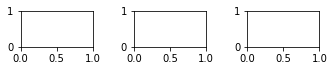

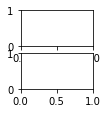

In [51]:


#Return to these cells to print out relevant information for reporting
head_pos = []
time_pos = []

head_neg = []
time_neg = []
######################################################


pos_tt_count =0
neg_tt_count =0
#Removed Plotting Intermediate for figure NB

# fig = plt.figure(figsize=(10,3))
# ax1 = fig.add_subplot(121)
# ax1.set_xlim(-100, 3000)

# ax2 = fig.add_subplot(122)
# ax2.set_xlim(-100, 3000)
print("Function is starting with " + str(len(uw_orco['obj_id_unique'].unique())))
print("First data pruning step")
for i in uw_orco['obj_id_unique'].unique():

    c=uw_orco[uw_orco['obj_id_unique']==i]
    time_vec = c['time stamp'].values
    head_vec= c['heading'].values

    initial_head = np.median( head_vec[(time_vec>-50)*(time_vec<0)] )
    sign = np.sign( initial_head )
    #head_vec *= sign
    #initial_head *= sign
    
    # signed ang vel
    a = unwrap_angle(c['heading'].values, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>-50)*(time_vec<3000) )
    ix_da = np.where( (time_vec>50)*(time_vec<200) )[0]
    if np.mean(da[ix_da]) > 0:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] < 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(h_flipped[ix_plot])
        time_pos.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
#         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
    else:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] > 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
                    
        head_neg.append(h_flipped[ix_plot])
        time_neg.append(time_vec[ix_plot])
        #x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
        #ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)

        
#######################################################################################
t_interp = np.arange(-50, 3000, 10)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    head_neg_interp.append(head_interp)
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )
print("After first step there are " +str(len(head_neg_interp)+len(head_pos_interp))+ " trajectories in tact")


########################################################################################
# group 1 -- flies deviate more than the difference between heading and upwind
head_pos_interp_g1 = []
head_pos_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_pos_interp.shape[0]):
    h = head_pos_interp[r,:]
    if np.max(h[ix]) > (h[0]+0.3925): # <<<< arbitrary
        head_pos_interp_g1.append(h)
    else:
        head_pos_interp_g0.append(h)
        
head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

# print(len(head_pos_interp_g1))
# print(len(head_pos_interp_g0))
# group 1 -- flies deviate more than the difference between heading and upwind
head_neg_interp_g1 = []
head_neg_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_neg_interp.shape[0]):
    h = head_neg_interp[r,:]
    if np.min(h[ix]) < h[0]-0.3925: # <<<< arbitrary
        head_neg_interp_g1.append(h)
    else:
        head_neg_interp_g0.append(h)
        
head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
head_neg_interp_g0 = np.vstack(head_neg_interp_g0)

# print("Lenght of head neg interp  group 1 vector is " +str(len(head_neg_interp_g1)))
# print("Lenght of head neg interp  group 0 vector is " +str(len(head_neg_interp_g0)))
###########################################################################################
t_interp = t_interp.astype(float)
###########################################################################################

#Setting up the upwind axexs for raw plots
layout =fifi.svg_to_axes.FigureLayout(s8_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax=layout.axes[('orco_uw', 'pos')]
ax1= layout.axes[('orco_uw', 'neg')]

############################################################################################
yticks = [-3.14, -1.57, 0, 1.57, 3.14]
#fig, ax = plt.subplots(3, 1, figsize = (3, 8))

ax.set_yticklabels([])
# plot raw

ax.set_xlim(-50, 1000)
ax.set_ylim(-3.4, 3.4)
ax.plot([0, 675], [3.3, 3.3], color = 'red', linewidth = .5)
xticks = [0, 675, 1000]

print('N trajecs in raw panel pos: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
print('N trajecs in raw panel neg: ', head_neg_interp_g1.shape[0] + head_neg_interp_g0.shape[0])


r = plot_raw_course_single_ax(head_pos_interp_g1, ax,  linewidth=.2, alpha = 0.5,c1=c1, c2 =c2)
#anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns_uw_pos, n_without_2_turns_uw_pos = r

r2 = plot_raw_course_single_ax(head_neg_interp_g1, ax1, linewidth=.2,alpha = 0.5, direction=None, c1=c1, c2=c2)
#anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns_uw_neg, n_without_2_turns_uw_neg = r2

#Plot centered isolated turns
#r3 = plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax2, ax3, linewidth=.2, alpha = 0.5,c1=c1, c2 =c2)


#r4 = plot_split_trajecs_turn_aligner(head_neg_interp_g1, ax2, ax3, linewidth=.2,alpha = 0.5, direction=None, c1=c1, c2=c2)
print("data structure of head_interp_groups is")
print(len(head_pos_interp_g0))
print("data structure of head_interp_groups is")
print(len(head_neg_interp_g0))

# r = plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax1, ax2)
# r2 = plot_split_trajecs_turn_aligner(head_neg_interp_g1, ax1, ax2, direction=None)

anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns, n_without_2_turns = r
anemometric_saccade_info_uwneg, anemotaxis_saccade_info_uwneg, n_with_2_turns, n_without_2_turns = r2
#for r in range(head_pos_interp_g0.shape[0]):
#    ax2.plot(t_interp, head_pos_interp_g0[r], linewidth=0.5, color='lightskyblue', alpha=0.5)
ax.set_xlim(-50, 1000)
ax1.set_xlim(-50, 1000)
ax1.set_ylim(-3.4, 3.4)
ax1.set_yticklabels([])
xticks = [0, 675, 1000]
#print('N trajecs in raw panel: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)


xticks = [0, 675, 1000]

#####################################################################################################
#Plotting leftover trajectoryes
for r in range(len(head_neg_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

for r in range(len(head_pos_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

fifi.mpl_functions.set_fontsize(ax, fs)

layout.append_figure_to_layer(layout.figures['orco_uw'], 'orco_uw', cleartarget=True)

layout.write_svg(s8_template)

#


# Orco Crosswind Subset

26
8
34
15
N trajecs in raw panel:  34
Two Turn Seqs detected = 46


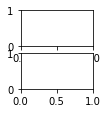

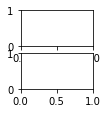

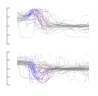

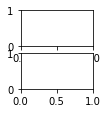

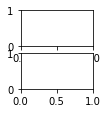

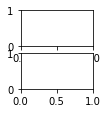

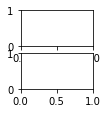

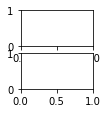

In [6968]:
head_pos = []
time_pos = []

head_neg = []
time_neg = []

#########################################
for i in cw_orco['obj_id_unique'].unique():

    c=cw_orco[cw_orco['obj_id_unique']==i]
    time_vec = c['time stamp'].values
    head_vec= c['heading'].values

    initial_head = np.median( head_vec[(time_vec>-50)*(time_vec<0)] )
    sign = np.sign( initial_head )
    head_vec *= sign
    initial_head *= sign
    
    # signed ang vel
    a = unwrap_angle(c['heading'].values, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>-50)*(time_vec<3000) )
    ix_da = np.where( (time_vec>50)*(time_vec<200) )[0]
    if np.mean(da[ix_da]) > 0:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] < 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(h_flipped[ix_plot])
        time_pos.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
#         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
    else:
        head_neg.append(head_vec[ix_plot])
        time_neg.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, head_vec, jump=np.pi/2)
#         ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)

####################################################################################################
t_interp = np.arange(-50, 3000, 10)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    head_neg_interp.append(head_interp)
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )
# group 1 -- flies deviate more than the difference between heading and upwind
head_pos_interp_g1 = []
head_pos_interp_g0 = []

ix = np.where(t_interp < 500)

for r in range(head_pos_interp.shape[0]):
    h = head_pos_interp[r,:]
    if np.max(h[ix]) > (1.57+0.3925): # <<<< arbitrary
        head_pos_interp_g1.append(h)
    else:
        head_pos_interp_g0.append(h)
        
head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

print(len(head_pos_interp_g1))
print(len(head_pos_interp_g0))
# group 1 -- flies deviate more than the difference between heading and upwind
head_neg_interp_g1 = []
head_neg_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_neg_interp.shape[0]):
    h = head_neg_interp[r,:]
    if np.min(h[ix]) < -0.3925: # <<<< arbitrary
        head_neg_interp_g1.append(h)
    else:
        head_neg_interp_g0.append(h)
        
head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
head_neg_interp_g0 = np.vstack(head_neg_interp_g0)

print(len(head_neg_interp_g1))
print(len(head_neg_interp_g0))

##################################################################################
t_interp = t_interp.astype(float)
##################################################################################
layout =fifi.svg_to_axes.FigureLayout(s8_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax=layout.axes[('orco_cw', 'pos')]
ax1= layout.axes[('orco_cw', 'neg')]


##################################################################################
yticks = [-3.14, -1.57, 0, 1.57, 3.14]
#fig, ax = plt.subplots(3, 1, figsize = (3, 8))
ax.set_yticklabels([])
ax.set_xlim(-50, 1000)
# plot raw
# for i in cw_orco['obj_id_unique'].unique():
#     c = cw_orco[cw_orco['obj_id_unique']==i]
#     x =c['time stamp'].to_numpy()
#     y=c['heading'].to_numpy()
#     x, y = remove_discontinuities(x, y, jump=np.pi/2)
#     ax.plot(x, y, color = 'gray',linewidth = 0.5, alpha = 0.2,  markeredgecolor = None)

ax.set_xlim(-50, 1000)
ax.set_ylim(-3.14, 3.14)
xticks = [0, 675, 1000]

ax1.set_xlim(-50, 1000)
print('N trajecs in raw panel: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)


# plot the broken and leftover trajectories

r = plot_raw_course_single_ax(head_pos_interp_g1, ax, c1=c1, c2=c2, alpha = 0.5)
r2 = plot_raw_course_single_ax(head_neg_interp_g1, ax1, alpha = 0.5, direction=None, c1=c1, c2= c2)

# anemometric_saccade_info_cwpos, anemotaxis_saccade_info_cwpos, n_with_2_turns_cw_pos, n_without_2_turns = r
# anemometric_saccade_info_cwneg, anemotaxis_saccade_info_cwneg, n_with_2_turns_cw_neg, n_without_2_turns = r2

for r in range(len(head_neg_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

for r in range(len(head_pos_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)



#ax1.set_xlim(-150, 150)
ax1.set_ylim(-3.4, 3.4)
ax1.set_yticklabels([])
xticks = [0, 675, 1000]

fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=yticks, linewidth = lw, tick_length=3 )
fifi.mpl_functions.adjust_spines(ax2, [], xticks=[], yticks=yticks)
fifi.mpl_functions.adjust_spines(ax3, [], xticks=[], yticks=yticks)





print("Two Turn Seqs detected = " + str(n_with_2_turns_cw_neg+n_with_2_turns_cw_pos))
fifi.mpl_functions.set_fontsize(ax, fs)


layout.append_figure_to_layer(layout.figures['orco_cw'], 'orco_cw', cleartarget=True)

layout.write_svg(s8_template)
#layout.append_figure_to_layer(layout.figures['upwind_pos'], 'upwind_pos', cleartarget=True)
#layout.write_svg('anemo_metric_taxis.svg')


# No wind Orco For Supplement- not in latest figure version

Starting with n=275
dropping short trajec:  909_20220814_165127


/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dropping short trajec:  27591_20220814_165127
dropping short trajec:  5417_20220815_162329
dropping short trajec:  45875_20220815_162329
dropping short trajec:  1297_20220817_173045
dropping short trajec:  3029_20220817_173045


KeyError: ('orco_nw', 'pos')

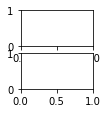

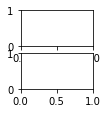

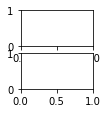

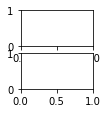

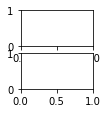

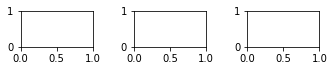

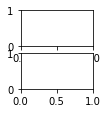

In [52]:
# head_pos = []
# time_pos = []
# objid_pos = []

# head_neg = []
# time_neg = []
# objid_neg = []
# print("Starting with n=" +str(len(nw100['obj_id_unique'].unique())))
# ########################################################
# for i in nw100['obj_id_unique'].unique():
    
#     c=nw100[nw100['obj_id_unique']==i]
    
#     if c.shape[0] < 200:
#         print('dropping short trajec: ', i)
#         continue
        
    
#     time_vec = c['time stamp'].values
#     head_vec= c['heading'].values

#     ix_plot = np.where( (time_vec>-200)*(time_vec<3000) )
    
#     time_vec = time_vec[ix_plot]
#     head_vec = head_vec[ix_plot]
#     head_vec = unwrap_angle(head_vec, 4)
    
#     ix = np.where( (time_vec>-50)*(time_vec<0) )
#     head_vec -= np.mean(head_vec[ix])
#     #head_vec = wrap_angle(head_vec)
    
#     # signed ang vel
#     smootha, da = pynumdiff.linear_model.savgoldiff(head_vec, dt, [3,20,20])
    
#     ix = np.where( (time_vec>0)*(time_vec<200) )
#     if np.mean(da[ix]) > 0:
# #         x, y =remove_discontinuities(time_vec, head_vec, jump=np.pi/2)
# #         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
#         head_pos.append(head_vec)
#         time_pos.append(time_vec)
#         objid_pos.append(i)
#     else:
# #         x, y =remove_discontinuities(time_vec, head_vec, jump=np.pi/2)
# #         ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
#         head_neg.append(head_vec)
#         time_neg.append(time_vec)
#         objid_neg.append(i)
        
# #########################################################################
# t_interp = np.arange(-50, 1000, 10)

# head_pos_interp = []
# for r in range(len(head_pos)):
#     head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
#     ix = np.where(t_interp < np.min(time_pos[r]) )
#     head_interp[ix] = np.nan
#     ix = np.where(t_interp > np.max(time_pos[r]) )
#     head_interp[ix] = np.nan
#     head_pos_interp.append(head_interp)
    
# head_neg_interp = []
# for r in range(len(head_neg)):
#     head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
#     ix = np.where(t_interp < np.min(time_neg[r]) )
#     head_interp[ix] = np.nan
#     ix = np.where(t_interp > np.max(time_neg[r]) )
#     head_interp[ix] = np.nan
#     head_neg_interp.append(head_interp)
    
    
# #########################################################################

# head_neg_interp = np.vstack( head_neg_interp )
# head_pos_interp = np.vstack( head_pos_interp )

# ##########################################################################

# # group 1 -- flies deviate more than the difference between heading and upwind
# head_pos_interp_g1 = []
# last_odor_pos_g1 = []
# head_pos_interp_g0 = []
# last_odor_pos_g0 = []

# ix = np.where( (t_interp>-50)*(t_interp < 300) )
# for r in range(head_pos_interp.shape[0]):
#     c=nw100[nw100['obj_id_unique']==objid_pos[r]]
#     h = head_pos_interp[r,:]
#     if np.max(h[ix]) > (0.3925): # <<<< arbitrary
#         head_pos_interp_g1.append(h)
#         last_odor_pos_g1.append(c.last_flash.mean())
#     else:
#         head_pos_interp_g0.append(h)
#         last_odor_pos_g0.append(c.last_flash.mean())
        
# head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
# head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

# # print(len(head_pos_interp_g1))
# # print(len(head_pos_interp_g0))
# #########################################################################


# head_neg_interp_g1 = []
# head_neg_interp_g0 = []

# ix = np.where( (t_interp>-50)*(t_interp < 300) )
# for r in range(head_neg_interp.shape[0]):
#     h = head_neg_interp[r,:]
#     if np.min(h[ix]) < -0.3925: # <<<< arbitrary
#         head_neg_interp_g1.append(h)
#     else:
#         head_neg_interp_g0.append(h)
        
# head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
# head_neg_interp_g0 = np.vstack(head_neg_interp_g0)


# ###########################################################################
# t_interp = t_interp.astype(float)
# ###########################################################################
# layout =fifi.svg_to_axes.FigureLayout(s8_template,
#                                       autogenlayers=True, make_mplfigures=True, hide_layers=[])
# ax = layout.axes[('orco_nw', 'pos')]
# ax1 = layout.axes[('orco_nw', 'neg')]

# ############################################################################

# for r in range(len(head_neg_interp_g0)):
#     x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
#     ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.4)

# for r in range(len(head_pos_interp_g0)):
#     x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
#     ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.4)

# ax.set_xlim(-50, 1000)
# ax.set_ylim(-4, 4)
# xticks = [0, 675, 1000]
# ax.set_yticklabels([])
# print('N trajecs in raw panel: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
# fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks)


# r = plot_raw_trajecs_single_axis_no_wind(head_pos_interp_g1, ax, linewidth=.2, alpha = 0.6,cnw=cnw)
# anemometric_saccade_info_nwpos, n_with_1_turn_nw_pos, n_without_1_turn = r
# r2 = plot_raw_trajecs_single_axis_no_wind(head_neg_interp_g1, ax1, linewidth=.2, alpha = 0.6,cnw=cnw, direction=None)
# anemometric_saccade_info_nwneg, n_with_1_turn_nw_neg, n_without_1_turn = r2

# ax1.set_xlim(-50, 1000)
# ax1.set_ylim(-4, 4)
# xticks = [0, 675, 1000]

# ax1.set_yticklabels([])



# fifi.mpl_functions.set_fontsize(ax, 5)


# ax.set_xlim(-50, 1000)
# ax.set_ylim(-4, 4)
# xticks = [0, 675, 1000]

# print('N trajecs in raw panel: ', head_neg_interp_g1.shape[0] + head_neg_interp_g0.shape[0])



# ax1.set_xlim(-50, 1000)
# ax1.set_ylim(-4, 4)
# xticks = [0, 675, 1000]

# #print('N trajecs in raw panel: ', head_neg_interp_g1.shape[0] + head_neg_interp_g0.shape[0])
# fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=[], yticks=yticks, tick_length=3, linewidth = lw)
# fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=yticks, tick_length =3, linewidth = lw)


# #ax2.set_xlim(-50, 1000)
# #ax2.set_ylim(-4, 4)

# print("No wind course change count = " +str(n_with_1_turn_nw_neg +n_with_1_turn_nw_pos))
# ##########################################################################
# layout.append_figure_to_layer(layout.figures['orco_nw'], 'orco_nw', cleartarget=True)

# layout.write_svg(s8_template)


# No wind Orco shams for baseline turn probability based on the algorithm
# Not in final Version

In [53]:
# head_pos = []
# time_pos = []
# objid_pos = []

# head_neg = []
# time_neg = []
# objid_neg = []
# print("Starting with n=" +str(len(nw0['obj_id_unique'].unique())))
# ########################################################
# for i in nw0['obj_id_unique'].unique():
    
#     c=nw0[nw0['obj_id_unique']==i]
    
#     if c.shape[0] < 200:
#         print('dropping short trajec: ', i)
#         continue
        
    
#     time_vec = c['time stamp'].values
#     head_vec= c['heading'].values

#     ix_plot = np.where( (time_vec>-200)*(time_vec<3000) )
    
#     time_vec = time_vec[ix_plot]
#     head_vec = head_vec[ix_plot]
#     head_vec = unwrap_angle(head_vec, 4)
    
#     ix = np.where( (time_vec>-50)*(time_vec<0) )
#     head_vec -= np.mean(head_vec[ix])
#     #head_vec = wrap_angle(head_vec)
    
#     # signed ang vel
#     smootha, da = pynumdiff.linear_model.savgoldiff(head_vec, dt, [3,20,20])
    
#     ix = np.where( (time_vec>0)*(time_vec<200) )
#     if np.mean(da[ix]) > 0:
# #         x, y =remove_discontinuities(time_vec, head_vec, jump=np.pi/2)
# #         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
#         head_pos.append(head_vec)
#         time_pos.append(time_vec)
#         objid_pos.append(i)
#     else:
# #         x, y =remove_discontinuities(time_vec, head_vec, jump=np.pi/2)
# #         ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
#         head_neg.append(head_vec)
#         time_neg.append(time_vec)
#         objid_neg.append(i)
        
# #########################################################################
# t_interp = np.arange(-50, 1000, 10)

# head_pos_interp = []
# for r in range(len(head_pos)):
#     head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
#     ix = np.where(t_interp < np.min(time_pos[r]) )
#     head_interp[ix] = np.nan
#     ix = np.where(t_interp > np.max(time_pos[r]) )
#     head_interp[ix] = np.nan
#     head_pos_interp.append(head_interp)
    
# head_neg_interp = []
# for r in range(len(head_neg)):
#     head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
#     ix = np.where(t_interp < np.min(time_neg[r]) )
#     head_interp[ix] = np.nan
#     ix = np.where(t_interp > np.max(time_neg[r]) )
#     head_interp[ix] = np.nan
#     head_neg_interp.append(head_interp)
    
    
# #########################################################################

# head_neg_interp = np.vstack( head_neg_interp )
# head_pos_interp = np.vstack( head_pos_interp )

# ##########################################################################

# # group 1 -- flies deviate more than the difference between heading and upwind
# head_pos_interp_g1 = []
# last_odor_pos_g1 = []
# head_pos_interp_g0 = []
# last_odor_pos_g0 = []

# ix = np.where( (t_interp>-50)*(t_interp < 200) )
# for r in range(head_pos_interp.shape[0]):
#     c=nw100[nw100['obj_id_unique']==objid_pos[r]]
#     h = head_pos_interp[r,:]
#     if np.max(h[ix]) > (0.3925): # <<<< arbitrary
#         head_pos_interp_g1.append(h)
#         last_odor_pos_g1.append(c.last_flash.mean())
#     else:
#         head_pos_interp_g0.append(h)
#         last_odor_pos_g0.append(c.last_flash.mean())
        
# head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
# head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

# # print(len(head_pos_interp_g1))
# # print(len(head_pos_interp_g0))
# #########################################################################


# head_neg_interp_g1 = []
# head_neg_interp_g0 = []

# ix = np.where( (t_interp>-50)*(t_interp < 200) )
# for r in range(head_neg_interp.shape[0]):
#     h = head_neg_interp[r,:]
#     if np.min(h[ix]) < -0.3925: # <<<< arbitrary
#         head_neg_interp_g1.append(h)
#     else:
#         head_neg_interp_g0.append(h)
        
# head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
# head_neg_interp_g0 = np.vstack(head_neg_interp_g0)


# ###########################################################################
# t_interp = t_interp.astype(float)
# ###########################################################################
# fig, ax_= plt.subplots(2, 1, figsize= (4, 4))
# ax=ax_[0]
# ax1=ax_[1]
# ############################################################################

# for r in range(len(head_neg_interp_g0)):
#     x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
#     ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.4)

# for r in range(len(head_pos_interp_g0)):
#     x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
#     ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.4)

# ax.set_xlim(-50, 1000)
# ax.set_ylim(-4, 4)
# xticks = [0, 675, 1000]
# ax.set_yticklabels([])
# print('N trajecs in raw panel: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
# fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks)


# r = plot_raw_trajecs_single_axis_no_wind(head_pos_interp_g1, ax, linewidth=.2, alpha = 0.6,cnw=cnw)
# anemometric_saccade_info_nwpos, n_with_1_turn_nw_pos, n_without_1_turn = r
# r2 = plot_raw_trajecs_single_axis_no_wind(head_neg_interp_g1, ax1, linewidth=.2, alpha = 0.6,cnw=cnw, direction=None)
# anemometric_saccade_info_nwneg, n_with_1_turn_nw_neg, n_without_1_turn = r2

# ax1.set_xlim(-50, 1000)
# ax1.set_ylim(-4, 4)
# xticks = [0, 675, 1000]

# ax1.set_yticklabels([])



# fifi.mpl_functions.set_fontsize(ax, 5)


# ax.set_xlim(-50, 1000)
# ax.set_ylim(-4, 4)
# xticks = [0, 675, 1000]

# print('N trajecs in raw panel: ', head_neg_interp_g1.shape[0] + head_neg_interp_g0.shape[0])



# ax1.set_xlim(-50, 1000)
# ax1.set_ylim(-4, 4)
# xticks = [0, 675, 1000]

# #print('N trajecs in raw panel: ', head_neg_interp_g1.shape[0] + head_neg_interp_g0.shape[0])
# fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=[], yticks=yticks, tick_length=3, linewidth = lw)
# fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=yticks, tick_length =3, linewidth = lw)


# #ax2.set_xlim(-50, 1000)
# #ax2.set_ylim(-4, 4)

# print("No wind course change count = " +str(n_with_1_turn_nw_neg +n_with_1_turn_nw_pos))
# ##########################################################################
# # layout.append_figure_to_layer(layout.figures['orco_nw'], 'orco_nw', cleartarget=True)

# # layout.write_svg(supp_path + 'startle_control.svg')


# Wild type flies control to show pre-turn isnt a visually mediated startle response

In [55]:
wt=pd.read_csv('../trimmed_data/main/wild_type_laminar_merged.csv')

In [56]:
wt=wt[wt['time stamp'].between(-100, 5000)]
wt['ground speed']=(wt['xvel']**2+wt['yvel']**2)**.5
#get only subsret that recieved a flash
wt100=wt[wt['duration']==100]
holder_vec =[]
#longer trajectories only
for i in wt100['obj_id_unique'].unique():
    d =wt100[wt100['obj_id_unique']==i]
    if d['time stamp'].max()>1680:
        holder_vec.append(d)
wt100=pd.concat(holder_vec)

In [57]:
#split wild type data into similar, upwind, crosswind, and downwind data sets
wt100['abs ang vel']=np.abs(wt100['theta dot smooth'])
cw=[]
uw=[]
dw=[]
for i in wt100['obj_id_unique'].unique():
    d =wt100[wt100['obj_id_unique']==i]
    ind=np.where(d['time stamp']==0)[0][0]
    o=np.abs(d['heading'].iloc[ind])
    #print(o)
    if o<=np.pi/4:
        uw.append(i)
    if o> np.pi/4 and o <=(3.*np.pi/4):
        cw.append(i)
    elif o >(3.*np.pi/4):
        dw.append(i)


#Subslice the laminar wind data set        
cw_wt=wt100[wt100['obj_id_unique'].isin(cw)]
uw_wt=wt100[wt100['obj_id_unique'].isin(uw)]
dw_wt=wt100[wt100['obj_id_unique'].isin(dw)]


# CsChrimson Heterozygotes to compare

In [64]:
u1wt=pd.read_csv('../trimmed_data/supp/CsChrimson_hets.csv')

In [65]:
u1wt100=u1wt[u1wt['duration']==100]
cw=[]
uw=[]
dw=[]
for i in u1wt100['obj_id_unique'].unique():
    d =u1wt100[u1wt100['obj_id_unique']==i]
    if d['time stamp'].max()>1680:
        ind=np.where(d['time stamp']==0)[0][0]
        o=np.abs(d['heading'].iloc[ind])
    #print(o)
        if o<=np.pi/4:
            uw.append(i)
        if o> np.pi/4 and o <=(3.*np.pi/4):
            cw.append(i)
        elif o >(3.*np.pi/4):
            dw.append(i)


#Subslice the laminar wind data set        
cw_u1wt=u1wt100[u1wt100['obj_id_unique'].isin(cw)]
uw_u1wt=u1wt100[u1wt100['obj_id_unique'].isin(uw)]
dw_u1wt=u1wt100[u1wt100['obj_id_unique'].isin(dw)]


# New function only detects turns that would meet "anemometric saccade" requirements, does not require a second saccade.

In [59]:
#Making a separate function just to detect sharp course changes, the other code requires two saccades
def plot_raw_course_single_ax_wt(head_pos_interp_g1, ax1,c_base ='gray',c1 =c1, c2=c2, direction='pos', linewidth=0.2, alpha =0.4):

    threshold = 0.004
    dt = 10
    
    #fig = plt.figure(figsize=(10,3))
    #ax1 = fig.add_subplot(121)
    #ax1.set_xlim(-500, 3000)

    #ax2 = fig.add_subplot(122)
    #ax2.set_xlim(-100, 3000)

    n_with_2_turns = 0
    n_without_2_turns = 0

    anemometric_saccade_info = {'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    anemotaxis_saccade_info = { 'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    for r in range(len(head_pos_interp_g1)):
        if direction == 'pos':
            a = unwrap_angle(head_pos_interp_g1[r] - np.pi, 5)
        else:
            a = unwrap_angle(head_pos_interp_g1[r] + np.pi, 5)
        smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,10,10])
        rawsmootha, rawda = pynumdiff.linear_model.savgoldiff(a, dt, [3,4,4]) #pynumdiff.finite_difference.first_order(a, dt)
        
        # anemometric
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
            
        last_ix = np.where(t_interp<450)[0][-1]
        first_ix = np.where(t_interp>10)[0][0]
        p = p[ (p<last_ix)*(p>first_ix)]
        if len(p)>0:
            ix_anemometric = p[0]

        if direction == 'pos':
            chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
        else:
            chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
        anemometric_saccade = None
        for chunk in chunks:
            if ix_anemometric in chunk:
                anemometric_saccade = chunk
                break

        

        # anemotaxis
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        first_ix = ix_anemometric
        last_ix = np.where(t_interp<750)[0][-1]
        p = p[ (p>first_ix)*(p<last_ix)]
        ix_anemotaxis = p[0]

        if direction == 'pos':
            chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
        else:
            chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
        anemotaxis_saccade = None
        for chunk in chunks:
            if ix_anemotaxis in chunk:
                anemotaxis_saccade = chunk
                break

        if anemometric_saccade is not None:
            peak = np.max( np.abs(rawda[anemometric_saccade]) )
            amplitude = (np.cumsum(rawda[anemometric_saccade])*dt)[-1]
            duration = t_interp[anemometric_saccade][-1] - t_interp[anemometric_saccade][0]
            end_point = head_pos_interp_g1[r][anemometric_saccade][-1]
            start_point = head_pos_interp_g1[r][anemometric_saccade][0]
            anemometric_saccade_info['peak_angular_velocity'].append( np.abs(peak) )
            anemometric_saccade_info['amplitude'].append(amplitude)
            anemometric_saccade_info['duration'].append(duration)
            anemometric_saccade_info['end_point'].append(end_point)
            anemometric_saccade_info['start_point'].append(start_point)
            
#             peak = np.max( np.abs(rawda[anemotaxis_saccade]) )
#             amplitude = (np.cumsum(rawda[anemotaxis_saccade])*dt)[-1]
#             duration = t_interp[anemotaxis_saccade][-1] - t_interp[anemotaxis_saccade][0]
#             end_point = head_pos_interp_g1[r][anemotaxis_saccade][-1]
#             start_point = head_pos_interp_g1[r][anemotaxis_saccade][0]

#             anemotaxis_saccade_info['peak_angular_velocity'].append(np.abs(peak))
#             anemotaxis_saccade_info['amplitude'].append(amplitude)
#             anemotaxis_saccade_info['duration'].append(duration)
#             anemotaxis_saccade_info['end_point'].append(end_point)
#             anemotaxis_saccade_info['start_point'].append(start_point)
        #ix_middle = int( (ix_anemotaxis - ix_anemometric)/2) + ix_anemometric
        #ax1.plot(t_interp[ixp], head_pos_interp_g1[r][ixp], '*')



        if anemometric_saccade is not None:
            n_with_2_turns += 1

            # before anemometric
            t_plot = t_interp[0:anemometric_saccade[0]]
            h_plot = head_pos_interp_g1[r][0:anemometric_saccade[0]]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)

            # anemometric
            t_plot = t_interp[anemometric_saccade]
            h_plot = head_pos_interp_g1[r][anemometric_saccade]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c1, linewidth = linewidth, alpha =alpha)

             # rest of trajectory
            t_plot = t_interp[anemometric_saccade[-1]:]
            h_plot = head_pos_interp_g1[r][anemometric_saccade[-1]:]
            x, y = remove_discontinuities(t_plot, h_plot)
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)

#             # anemotaxis
#             t_plot = t_interp[anemotaxis_saccade]
#             h_plot = head_pos_interp_g1[r][anemotaxis_saccade]
#             x, y = remove_discontinuities(t_plot, h_plot)
#             ax1.plot(x, y, color = c2, linewidth = linewidth, alpha =alpha)

#             # after anemotaxis
#             t_plot = t_interp[anemotaxis_saccade[-1]:] 
#             h_plot = head_pos_interp_g1[r][anemotaxis_saccade[-1]:]
#             x, y = remove_discontinuities(t_plot, h_plot)
#             ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =0.5)

        else:
            #print(r)
            n_without_2_turns += 1
            x, y = remove_discontinuities(t_interp, head_pos_interp_g1[r])
            ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)
    #ax1.plot(t_interp, np.mean(head_pos_interp_g1, axis=0), color='red')

    #print(n_with_2_turns)
    #print(n_without_2_turns)

    return 

def mean_angle(angle, axis=0):
    return np.arctan2(np.nanmean(np.sin(angle), axis=axis), np.nanmean(np.cos(angle), axis=axis))

# Wild type upwind controls


First data pruning step


/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


After first step there are 229 trajectories in tact
N trajecs in raw panel pos:  101
N trajecs in raw panel neg:  128
data structure of head_interp_groups is
37
data structure of head_interp_groups is
47


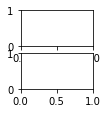

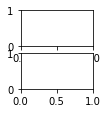

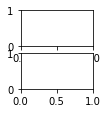

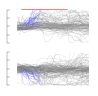

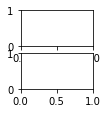

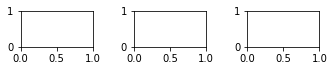

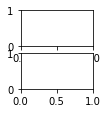

In [60]:


#Return to these cells to print out relevant information for reporting
head_pos = []
time_pos = []

head_neg = []
time_neg = []
######################################################


pos_tt_count =0
neg_tt_count =0
#Removed Plotting Intermediate for figure NB

# fig = plt.figure(figsize=(10,3))
# ax1 = fig.add_subplot(121)
# ax1.set_xlim(-100, 3000)

# ax2 = fig.add_subplot(122)
# ax2.set_xlim(-100, 3000)

print("First data pruning step")
for i in uw_wt['obj_id_unique'].unique():

    c=uw_wt[uw_wt['obj_id_unique']==i]
    time_vec = c['time stamp'].values
    head_vec= c['heading'].values

    initial_head = np.median( head_vec[(time_vec>-50)*(time_vec<0)] )
    sign = np.sign( initial_head )
    #head_vec *= sign
    #initial_head *= sign
    
    # signed ang vel
    a = unwrap_angle(c['heading'].values, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>-50)*(time_vec<3000) )
    ix_da = np.where( (time_vec>50)*(time_vec<200) )[0]
    if np.mean(da[ix_da]) > 0:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] < 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(h_flipped[ix_plot])
        time_pos.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
#         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
    else:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] > 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
                    
        head_neg.append(h_flipped[ix_plot])
        time_neg.append(time_vec[ix_plot])
        #x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
        #ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)

        
#######################################################################################
t_interp = np.arange(-50, 3000, 10)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    head_neg_interp.append(head_interp)
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )
print("After first step there are " +str(len(head_neg_interp)+len(head_pos_interp))+ " trajectories in tact")


########################################################################################
# group 1 -- flies deviate more than the difference between heading and upwind
head_pos_interp_g1 = []
head_pos_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_pos_interp.shape[0]):
    h = head_pos_interp[r,:]
    if np.max(h[ix]) > (h[0]+0.3925): # <<<< arbitrary
        head_pos_interp_g1.append(h)
    else:
        head_pos_interp_g0.append(h)
        
head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

# print(len(head_pos_interp_g1))
# print(len(head_pos_interp_g0))
# group 1 -- flies deviate more than the difference between heading and upwind
head_neg_interp_g1 = []
head_neg_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_neg_interp.shape[0]):
    h = head_neg_interp[r,:]
    if np.min(h[ix]) < h[0]-0.3925: # <<<< arbitrary
        head_neg_interp_g1.append(h)
    else:
        head_neg_interp_g0.append(h)
        
head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
head_neg_interp_g0 = np.vstack(head_neg_interp_g0)

# print("Lenght of head neg interp  group 1 vector is " +str(len(head_neg_interp_g1)))
# print("Lenght of head neg interp  group 0 vector is " +str(len(head_neg_interp_g0)))
###########################################################################################
t_interp = t_interp.astype(float)
###########################################################################################

#Setting up the upwind axexs for raw plots
layout =fifi.svg_to_axes.FigureLayout(s8_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax=layout.axes[('wt_uw', 'pos')]
ax1= layout.axes[('wt_uw', 'neg')]

############################################################################################
yticks = [-3.14, -1.57, 0, 1.57, 3.14]
#fig, ax = plt.subplots(3, 1, figsize = (3, 8))

ax.set_yticklabels([])
# plot raw

ax.set_xlim(-50, 1000)
ax.set_ylim(-3.4, 3.4)
ax.plot([0, 675], [3.3, 3.3], color = 'red', linewidth = .5)
xticks = [0, 675, 1000]

print('N trajecs in raw panel pos: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
print('N trajecs in raw panel neg: ', head_neg_interp_g1.shape[0] + head_neg_interp_g0.shape[0])


r = plot_raw_course_single_ax_wt(head_pos_interp_g1, ax,  linewidth=.2, alpha = 0.5,c1=c1, c2 =c2)
#anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns_uw_pos, n_without_2_turns_uw_pos = r

r2 = plot_raw_course_single_ax_wt(head_neg_interp_g1, ax1, linewidth=.2,alpha = 0.5, direction=None, c1=c1, c2=c2)
#anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns_uw_neg, n_without_2_turns_uw_neg = r2

#Plot centered isolated turns
#r3 = plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax2, ax3, linewidth=.2, alpha = 0.5,c1=c1, c2 =c2)


#r4 = plot_split_trajecs_turn_aligner(head_neg_interp_g1, ax2, ax3, linewidth=.2,alpha = 0.5, direction=None, c1=c1, c2=c2)
print("data structure of head_interp_groups is")
print(len(head_pos_interp_g0))
print("data structure of head_interp_groups is")
print(len(head_neg_interp_g0))

# r = plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax1, ax2)
# r2 = plot_split_trajecs_turn_aligner(head_neg_interp_g1, ax1, ax2, direction=None)

# anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns, n_without_2_turns = r
# anemometric_saccade_info_uwneg, anemotaxis_saccade_info_uwneg, n_with_2_turns, n_without_2_turns = r2
#for r in range(head_pos_interp_g0.shape[0]):
#    ax2.plot(t_interp, head_pos_interp_g0[r], linewidth=0.5, color='lightskyblue', alpha=0.5)
ax.set_xlim(-50, 1000)
ax1.set_xlim(-50, 1000)
ax1.set_ylim(-3.4, 3.4)
ax1.set_yticklabels([])
xticks = [0, 675, 1000]
#print('N trajecs in raw panel: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)


xticks = [0, 675, 1000]

#####################################################################################################
#Plotting leftover trajectoryes
for r in range(len(head_neg_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

for r in range(len(head_pos_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

fifi.mpl_functions.set_fontsize(ax, fs)

layout.append_figure_to_layer(layout.figures['wt_uw'], 'wt_uw', cleartarget=True)

layout.write_svg(s8_template)

#


# Wild type crosswind controls 

/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


36
13
24
40
N trajecs in raw panel:  49


/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


Two Turn Seqs detected = 46


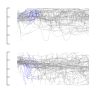

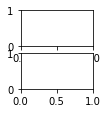

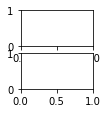

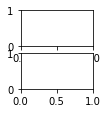

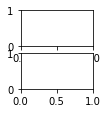

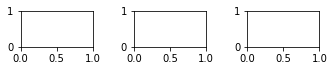

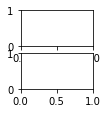

In [62]:
head_pos = []
time_pos = []

head_neg = []
time_neg = []

#########################################
for i in cw_wt['obj_id_unique'].unique():

    c=cw_wt[cw_wt['obj_id_unique']==i]
    time_vec = c['time stamp'].values
    head_vec= c['heading'].values

    initial_head = np.median( head_vec[(time_vec>-50)*(time_vec<0)] )
    sign = np.sign( initial_head )
    head_vec *= sign
    initial_head *= sign
    
    # signed ang vel
    a = unwrap_angle(c['heading'].values, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>-50)*(time_vec<3000) )
    ix_da = np.where( (time_vec>50)*(time_vec<200) )[0]
    if np.mean(da[ix_da]) > 0:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] < 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(h_flipped[ix_plot])
        time_pos.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
#         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
    else:
        head_neg.append(head_vec[ix_plot])
        time_neg.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, head_vec, jump=np.pi/2)
#         ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)

####################################################################################################
t_interp = np.arange(-50, 3000, 10)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    head_neg_interp.append(head_interp)
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )
# group 1 -- flies deviate more than the difference between heading and upwind
head_pos_interp_g1 = []
head_pos_interp_g0 = []

ix = np.where(t_interp < 500)

for r in range(head_pos_interp.shape[0]):
    h = head_pos_interp[r,:]
    if np.max(h[ix]) > (1.57+0.3925): # <<<< arbitrary
        head_pos_interp_g1.append(h)
    else:
        head_pos_interp_g0.append(h)
        
head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

print(len(head_pos_interp_g1))
print(len(head_pos_interp_g0))
# group 1 -- flies deviate more than the difference between heading and upwind
head_neg_interp_g1 = []
head_neg_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_neg_interp.shape[0]):
    h = head_neg_interp[r,:]
    if np.min(h[ix]) < -0.3925: # <<<< arbitrary
        head_neg_interp_g1.append(h)
    else:
        head_neg_interp_g0.append(h)
        
head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
head_neg_interp_g0 = np.vstack(head_neg_interp_g0)

print(len(head_neg_interp_g1))
print(len(head_neg_interp_g0))

##################################################################################
t_interp = t_interp.astype(float)
##################################################################################
layout =fifi.svg_to_axes.FigureLayout(s8_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax=layout.axes[('wt_cw', 'pos')]
ax1= layout.axes[('wt_cw', 'neg')]


##################################################################################
yticks = [-3.14, -1.57, 0, 1.57, 3.14]
#fig, ax = plt.subplots(3, 1, figsize = (3, 8))
ax.set_yticklabels([])
ax.set_xlim(-50, 1000)
# plot raw
# for i in cw_orco['obj_id_unique'].unique():
#     c = cw_orco[cw_orco['obj_id_unique']==i]
#     x =c['time stamp'].to_numpy()
#     y=c['heading'].to_numpy()
#     x, y = remove_discontinuities(x, y, jump=np.pi/2)
#     ax.plot(x, y, color = 'gray',linewidth = 0.5, alpha = 0.2,  markeredgecolor = None)

ax.set_xlim(-50, 1000)
ax.set_ylim(-3.14, 3.14)
xticks = [0, 675, 1000]

ax1.set_xlim(-50, 1000)
print('N trajecs in raw panel: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)


# plot the broken and leftover trajectories

r = plot_raw_course_single_ax_wt(head_pos_interp_g1, ax, c1=c1, c2=c2, alpha = 0.5)
r2 = plot_raw_course_single_ax_wt(head_neg_interp_g1, ax1, alpha = 0.5, direction=None, c1=c1, c2= c2)

# anemometric_saccade_info_cwpos, anemotaxis_saccade_info_cwpos, n_with_2_turns_cw_pos, n_without_2_turns = r
# anemometric_saccade_info_cwneg, anemotaxis_saccade_info_cwneg, n_with_2_turns_cw_neg, n_without_2_turns = r2

for r in range(len(head_neg_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

for r in range(len(head_pos_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)



#ax1.set_xlim(-150, 150)
ax1.set_ylim(-3.4, 3.4)
ax1.set_yticklabels([])
xticks = [0, 675, 1000]

fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=yticks, linewidth = lw, tick_length=3 )
fifi.mpl_functions.adjust_spines(ax2, [], xticks=[], yticks=yticks)
fifi.mpl_functions.adjust_spines(ax3, [], xticks=[], yticks=yticks)





print("Two Turn Seqs detected = " + str(n_with_2_turns_cw_neg+n_with_2_turns_cw_pos))
fifi.mpl_functions.set_fontsize(ax, fs)


layout.append_figure_to_layer(layout.figures['wt_cw'], 'wt_cw', cleartarget=True)

layout.write_svg(s8_template)
#layout.append_figure_to_layer(layout.figures['upwind_pos'], 'upwind_pos', cleartarget=True)
#layout.write_svg('anemo_metric_taxis.svg')


# Downwind Raw Trajectories for completion: first Orco

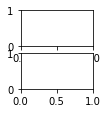

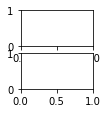

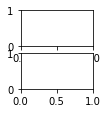

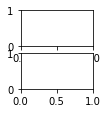

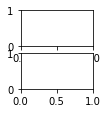

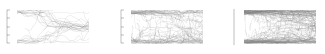

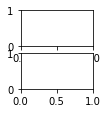

In [67]:
layout =fifi.svg_to_axes.FigureLayout(s8_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])
##################
#Orco unflipped
ax=layout.axes[('dw', 'orco')]
for i in dw_orco['obj_id_unique'].unique():
    t=dw_orco[dw_orco['obj_id_unique']==i]
    x, y = remove_discontinuities(t['time stamp'].to_numpy(), t['heading'].to_numpy())
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)


ax1= layout.axes[('dw', 'wt')]

#######
#Wild type unflipped
for i in dw_wt['obj_id_unique'].unique():
    t=dw_wt[dw_wt['obj_id_unique']==i]
    x, y = remove_discontinuities(t['time stamp'].to_numpy(), t['heading'].to_numpy())
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)
    
    
#u1wt unfipped
ax2 =layout.axes[('dw', 'u1')]
for i in dw_u1wt['obj_id_unique'].unique():
    t=dw_u1wt[dw_u1wt['obj_id_unique']==i]
    x, y = remove_discontinuities(t['time stamp'].to_numpy(), t['heading'].to_numpy())
    ax2.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)
    
    
#axis regularizing
ax.set_xlim(-50, 1000)
ax1.set_xlim(-50, 1000)
ax2.set_xlim(-50, 1000)

ax.set_ylim(-3.4, 3.4)
ax1.set_ylim(-3.4, 3.4)
ax2.set_ylim(-3.4, 3.4)

yticks = [-3.14, -1.57, 0, 1.57, 3.14]
ax.set_yticklabels([])
ax1.set_yticklabels([])
ax2.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=[], yticks=yticks, linewidth = lw, tick_length=3 )
fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=yticks, linewidth = lw, tick_length=3 )
fifi.mpl_functions.adjust_spines(ax2, ['left'], xticks=[], yticks=[], linewidth = lw, tick_length=3 )

layout.append_figure_to_layer(layout.figures['wt_cw'], 'wt_cw', cleartarget=True)

layout.write_svg(s8_template)
#layout.append_figure_to_layer(layout.figures['upwind_pos'], 'upwind_pos', cleartarget=True)
#layout.write_svg('anemo_metric_taxis.svg')

# CsChrimson Heterozygote data

In [68]:
#Making a separate function just to detect sharp course changes, the other code requires two saccades
#Only difference here was a lazy try statement to get around some bogie throwing the entire function off
def plot_raw_course_single_ax_u1wt(head_pos_interp_g1, ax1,c_base ='gray',c1 =c1, c2=c2, direction='pos', linewidth=0.2, alpha =0.4):

    threshold = 0.004
    dt = 10
    
    #fig = plt.figure(figsize=(10,3))
    #ax1 = fig.add_subplot(121)
    #ax1.set_xlim(-500, 3000)

    #ax2 = fig.add_subplot(122)
    #ax2.set_xlim(-100, 3000)

    n_with_2_turns = 0
    n_without_2_turns = 0

    anemometric_saccade_info = {'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    anemotaxis_saccade_info = { 'peak_angular_velocity': [],
                                'amplitude': [],
                                'duration': [],
                                'end_point': [],
                                'start_point': []}

    for r in range(len(head_pos_interp_g1)):

        if direction == 'pos':
            a = unwrap_angle(head_pos_interp_g1[r] - np.pi, 5)
        else:
            a = unwrap_angle(head_pos_interp_g1[r] + np.pi, 5)
        smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,10,10])
        rawsmootha, rawda = pynumdiff.linear_model.savgoldiff(a, dt, [3,4,4]) #pynumdiff.finite_difference.first_order(a, dt)
        
        # anemometric
        if direction == 'pos':
            p = scipy.signal.find_peaks_cwt(da, [4, 8])
        else:
            p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
            
        last_ix = np.where(t_interp<450)[0][-1]
        first_ix = np.where(t_interp>10)[0][0]
        p = p[ (p<last_ix)*(p>first_ix)]
        if len(p)>0:
            ix_anemometric = p[0]
        try:
            if direction == 'pos':
                chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
            else:
                chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
            anemometric_saccade = None
            for chunk in chunks:
                if ix_anemometric in chunk:
                    anemometric_saccade = chunk
                    break

        

        # anemotaxis
            if direction == 'pos':
                p = scipy.signal.find_peaks_cwt(-1*da, [4, 8])
            else:
                p = scipy.signal.find_peaks_cwt(da, [4, 8])
            first_ix = ix_anemometric
            last_ix = np.where(t_interp<750)[0][-1]
            p = p[ (p>first_ix)*(p<last_ix)]
            ix_anemotaxis = p[0]

            if direction == 'pos':
                chunks, breaks = flymath.get_continuous_chunks( np.where(da<-1*threshold)[0] )
            else:
                chunks, breaks = flymath.get_continuous_chunks( np.where(da>threshold)[0] )
            anemotaxis_saccade = None
            for chunk in chunks:
                if ix_anemotaxis in chunk:
                    anemotaxis_saccade = chunk
                    break

            if anemometric_saccade is not None:
                peak = np.max( np.abs(rawda[anemometric_saccade]) )
                amplitude = (np.cumsum(rawda[anemometric_saccade])*dt)[-1]
                duration = t_interp[anemometric_saccade][-1] - t_interp[anemometric_saccade][0]
                end_point = head_pos_interp_g1[r][anemometric_saccade][-1]
                start_point = head_pos_interp_g1[r][anemometric_saccade][0]
                anemometric_saccade_info['peak_angular_velocity'].append( np.abs(peak) )
                anemometric_saccade_info['amplitude'].append(amplitude)
                anemometric_saccade_info['duration'].append(duration)
                anemometric_saccade_info['end_point'].append(end_point)
                anemometric_saccade_info['start_point'].append(start_point)
            
#             peak = np.max( np.abs(rawda[anemotaxis_saccade]) )
#             amplitude = (np.cumsum(rawda[anemotaxis_saccade])*dt)[-1]
#             duration = t_interp[anemotaxis_saccade][-1] - t_interp[anemotaxis_saccade][0]
#             end_point = head_pos_interp_g1[r][anemotaxis_saccade][-1]
#             start_point = head_pos_interp_g1[r][anemotaxis_saccade][0]

#             anemotaxis_saccade_info['peak_angular_velocity'].append(np.abs(peak))
#             anemotaxis_saccade_info['amplitude'].append(amplitude)
#             anemotaxis_saccade_info['duration'].append(duration)
#             anemotaxis_saccade_info['end_point'].append(end_point)
#             anemotaxis_saccade_info['start_point'].append(start_point)
        #ix_middle = int( (ix_anemotaxis - ix_anemometric)/2) + ix_anemometric
        #ax1.plot(t_interp[ixp], head_pos_interp_g1[r][ixp], '*')



            if anemometric_saccade is not None:
                n_with_2_turns += 1

            # before anemometric
                t_plot = t_interp[0:anemometric_saccade[0]]
                h_plot = head_pos_interp_g1[r][0:anemometric_saccade[0]]
                x, y = remove_discontinuities(t_plot, h_plot)
                ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)

            # anemometric
                t_plot = t_interp[anemometric_saccade]
                h_plot = head_pos_interp_g1[r][anemometric_saccade]
                x, y = remove_discontinuities(t_plot, h_plot)
                ax1.plot(x, y, color = c1, linewidth = linewidth, alpha =alpha)

             # rest of trajectory
                t_plot = t_interp[anemometric_saccade[-1]:]
                h_plot = head_pos_interp_g1[r][anemometric_saccade[-1]:]
                x, y = remove_discontinuities(t_plot, h_plot)
                ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)

#             # anemotaxis
#             t_plot = t_interp[anemotaxis_saccade]
#             h_plot = head_pos_interp_g1[r][anemotaxis_saccade]
#             x, y = remove_discontinuities(t_plot, h_plot)
#             ax1.plot(x, y, color = c2, linewidth = linewidth, alpha =alpha)

#             # after anemotaxis
#             t_plot = t_interp[anemotaxis_saccade[-1]:] 
#             h_plot = head_pos_interp_g1[r][anemotaxis_saccade[-1]:]
#             x, y = remove_discontinuities(t_plot, h_plot)
#             ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =0.5)

            else:
            #print(r)
                n_without_2_turns += 1
                x, y = remove_discontinuities(t_interp, head_pos_interp_g1[r])
                ax1.plot(x, y, color = c_base, linewidth = linewidth, alpha =alpha)
        except:
            break
    #ax1.plot(t_interp, np.mean(head_pos_interp_g1, axis=0), color='red')

    #print(n_with_2_turns)
    #print(n_without_2_turns)

    return 

def mean_angle(angle, axis=0):
    return np.arctan2(np.nanmean(np.sin(angle), axis=axis), np.nanmean(np.cos(angle), axis=axis))

# Upwind subset

First data pruning step


/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


After first step there are 370 trajectories in tact
N trajecs in raw panel pos:  141
N trajecs in raw panel neg:  229
data structure of head_interp_groups is
47
data structure of head_interp_groups is
78


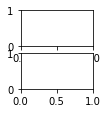

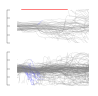

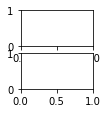

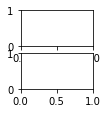

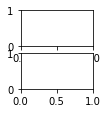

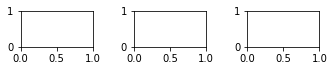

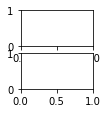

In [69]:


#Return to these cells to print out relevant information for reporting
head_pos = []
time_pos = []

head_neg = []
time_neg = []
######################################################


pos_tt_count =0
neg_tt_count =0
#Removed Plotting Intermediate for figure NB

# fig = plt.figure(figsize=(10,3))
# ax1 = fig.add_subplot(121)
# ax1.set_xlim(-100, 3000)

# ax2 = fig.add_subplot(122)
# ax2.set_xlim(-100, 3000)

print("First data pruning step")
for i in uw_u1wt['obj_id_unique'].unique():

    c=uw_u1wt[uw_u1wt['obj_id_unique']==i]
    time_vec = c['time stamp'].values
    head_vec= c['heading'].values

    initial_head = np.median( head_vec[(time_vec>-50)*(time_vec<0)] )
    sign = np.sign( initial_head )
    #head_vec *= sign
    #initial_head *= sign
    
    # signed ang vel
    a = unwrap_angle(c['heading'].values, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>-50)*(time_vec<3000) )
    ix_da = np.where( (time_vec>50)*(time_vec<200) )[0]
    if np.mean(da[ix_da]) > 0:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] < 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(h_flipped[ix_plot])
        time_pos.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
#         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
    else:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] > 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
                    
        head_neg.append(h_flipped[ix_plot])
        time_neg.append(time_vec[ix_plot])
        #x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
        #ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)

        
#######################################################################################
t_interp = np.arange(-50, 3000, 10)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    head_neg_interp.append(head_interp)
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )
print("After first step there are " +str(len(head_neg_interp)+len(head_pos_interp))+ " trajectories in tact")


########################################################################################
# group 1 -- flies deviate more than the difference between heading and upwind
head_pos_interp_g1 = []
head_pos_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_pos_interp.shape[0]):
    h = head_pos_interp[r,:]
    if np.max(h[ix]) > (h[0]+0.3925): # <<<< arbitrary
        head_pos_interp_g1.append(h)
    else:
        head_pos_interp_g0.append(h)
        
head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

# print(len(head_pos_interp_g1))
# print(len(head_pos_interp_g0))
# group 1 -- flies deviate more than the difference between heading and upwind
head_neg_interp_g1 = []
head_neg_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_neg_interp.shape[0]):
    h = head_neg_interp[r,:]
    if np.min(h[ix]) < h[0]-0.3925: # <<<< arbitrary
        head_neg_interp_g1.append(h)
    else:
        head_neg_interp_g0.append(h)
        
head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
head_neg_interp_g0 = np.vstack(head_neg_interp_g0)

# print("Lenght of head neg interp  group 1 vector is " +str(len(head_neg_interp_g1)))
# print("Lenght of head neg interp  group 0 vector is " +str(len(head_neg_interp_g0)))
###########################################################################################
t_interp = t_interp.astype(float)
###########################################################################################

#Setting up the upwind axexs for raw plots
layout =fifi.svg_to_axes.FigureLayout(s8_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax=layout.axes[('u1_uw', 'pos')]
ax1= layout.axes[('u1_uw', 'neg')]

############################################################################################
yticks = [-3.14, -1.57, 0, 1.57, 3.14]
#fig, ax = plt.subplots(3, 1, figsize = (3, 8))

ax.set_yticklabels([])
# plot raw

ax.set_xlim(-50, 1000)
ax.set_ylim(-3.4, 3.4)
ax.plot([0, 675], [3.3, 3.3], color = 'red', linewidth = .5)
xticks = [0, 675, 1000]

print('N trajecs in raw panel pos: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
print('N trajecs in raw panel neg: ', head_neg_interp_g1.shape[0] + head_neg_interp_g0.shape[0])


r = plot_raw_course_single_ax_u1wt(head_pos_interp_g1, ax,  linewidth=.2, alpha = 0.5,c1=c1, c2 =c2)
#anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns_uw_pos, n_without_2_turns_uw_pos = r

r2 = plot_raw_course_single_ax_u1wt(head_neg_interp_g1, ax1, linewidth=.2,alpha = 0.5, direction=None, c1=c1, c2=c2)
#anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns_uw_neg, n_without_2_turns_uw_neg = r2

#Plot centered isolated turns
#r3 = plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax2, ax3, linewidth=.2, alpha = 0.5,c1=c1, c2 =c2)


#r4 = plot_split_trajecs_turn_aligner(head_neg_interp_g1, ax2, ax3, linewidth=.2,alpha = 0.5, direction=None, c1=c1, c2=c2)
print("data structure of head_interp_groups is")
print(len(head_pos_interp_g0))
print("data structure of head_interp_groups is")
print(len(head_neg_interp_g0))

# r = plot_split_trajecs_turn_aligner(head_pos_interp_g1, ax1, ax2)
# r2 = plot_split_trajecs_turn_aligner(head_neg_interp_g1, ax1, ax2, direction=None)

# anemometric_saccade_info_uwpos, anemotaxis_saccade_info_uwpos, n_with_2_turns, n_without_2_turns = r
# anemometric_saccade_info_uwneg, anemotaxis_saccade_info_uwneg, n_with_2_turns, n_without_2_turns = r2
#for r in range(head_pos_interp_g0.shape[0]):
#    ax2.plot(t_interp, head_pos_interp_g0[r], linewidth=0.5, color='lightskyblue', alpha=0.5)
ax.set_xlim(-50, 1000)
ax1.set_xlim(-50, 1000)
ax1.set_ylim(-3.4, 3.4)
ax1.set_yticklabels([])
xticks = [0, 675, 1000]
#print('N trajecs in raw panel: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)


xticks = [0, 675, 1000]

#####################################################################################################
#Plotting leftover trajectoryes
for r in range(len(head_neg_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

for r in range(len(head_pos_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

fifi.mpl_functions.set_fontsize(ax, fs)

layout.append_figure_to_layer(layout.figures['u1_uw'], 'u1_uw', cleartarget=True)

layout.write_svg(s8_template)

#


# Crosswind Subset

/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


51
21
34
70
N trajecs in raw panel:  72


/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


Two Turn Seqs detected = 46


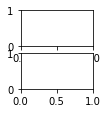

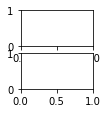

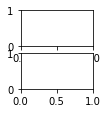

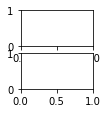

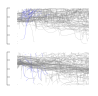

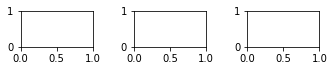

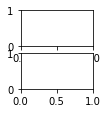

In [70]:
head_pos = []
time_pos = []

head_neg = []
time_neg = []

#########################################
for i in cw_u1wt['obj_id_unique'].unique():

    c=cw_u1wt[cw_u1wt['obj_id_unique']==i]
    time_vec = c['time stamp'].values
    head_vec= c['heading'].values

    initial_head = np.median( head_vec[(time_vec>-50)*(time_vec<0)] )
    sign = np.sign( initial_head )
    head_vec *= sign
    initial_head *= sign
    
    # signed ang vel
    a = unwrap_angle(c['heading'].values, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>-50)*(time_vec<3000) )
    ix_da = np.where( (time_vec>50)*(time_vec<200) )[0]
    if np.mean(da[ix_da]) > 0:
        
        h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
        h_flipped = []
        for chunk in range(len(h)):
            if len(h[chunk]) > 0:
                if t[chunk][0] > 0: # if time is after stimulus, consider flipping
                    if h[chunk][0] < 0:
                        #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
                    else:
                        #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                        h_flipped = np.hstack((h_flipped, h[chunk]))
                else:
                    #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
                    h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(h_flipped[ix_plot])
        time_pos.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, h_flipped, jump=np.pi/2)
#         ax1.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)
    else:
        head_neg.append(head_vec[ix_plot])
        time_neg.append(time_vec[ix_plot])
#         x, y =remove_discontinuities(time_vec, head_vec, jump=np.pi/2)
#         ax2.plot(x, y, color = 'gray', linewidth = 1.5, alpha =0.15)

####################################################################################################
t_interp = np.arange(-50, 3000, 10)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    head_neg_interp.append(head_interp)
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )
# group 1 -- flies deviate more than the difference between heading and upwind
head_pos_interp_g1 = []
head_pos_interp_g0 = []

ix = np.where(t_interp < 500)

for r in range(head_pos_interp.shape[0]):
    h = head_pos_interp[r,:]
    if np.max(h[ix]) > (1.57+0.3925): # <<<< arbitrary
        head_pos_interp_g1.append(h)
    else:
        head_pos_interp_g0.append(h)
        
head_pos_interp_g1 = np.vstack(head_pos_interp_g1)
head_pos_interp_g0 = np.vstack(head_pos_interp_g0)

print(len(head_pos_interp_g1))
print(len(head_pos_interp_g0))
# group 1 -- flies deviate more than the difference between heading and upwind
head_neg_interp_g1 = []
head_neg_interp_g0 = []

ix = np.where(t_interp < 500)
for r in range(head_neg_interp.shape[0]):
    h = head_neg_interp[r,:]
    if np.min(h[ix]) < -0.3925: # <<<< arbitrary
        head_neg_interp_g1.append(h)
    else:
        head_neg_interp_g0.append(h)
        
head_neg_interp_g1 = np.vstack(head_neg_interp_g1)
head_neg_interp_g0 = np.vstack(head_neg_interp_g0)

print(len(head_neg_interp_g1))
print(len(head_neg_interp_g0))

##################################################################################
t_interp = t_interp.astype(float)
##################################################################################
layout =fifi.svg_to_axes.FigureLayout(s8_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax=layout.axes[('u1_cw', 'pos')]
ax1= layout.axes[('u1_cw', 'neg')]


##################################################################################
yticks = [-3.14, -1.57, 0, 1.57, 3.14]
#fig, ax = plt.subplots(3, 1, figsize = (3, 8))
ax.set_yticklabels([])
ax.set_xlim(-50, 1000)
# plot raw
# for i in cw_orco['obj_id_unique'].unique():
#     c = cw_orco[cw_orco['obj_id_unique']==i]
#     x =c['time stamp'].to_numpy()
#     y=c['heading'].to_numpy()
#     x, y = remove_discontinuities(x, y, jump=np.pi/2)
#     ax.plot(x, y, color = 'gray',linewidth = 0.5, alpha = 0.2,  markeredgecolor = None)

ax.set_xlim(-50, 1000)
ax.set_ylim(-3.14, 3.14)
xticks = [0, 675, 1000]

ax1.set_xlim(-50, 1000)
print('N trajecs in raw panel: ', head_pos_interp_g1.shape[0] + head_pos_interp_g0.shape[0])
fifi.mpl_functions.adjust_spines(ax, ['left'], xticks=xticks, yticks=yticks, tick_length=3, linewidth=lw)


# plot the broken and leftover trajectories

r = plot_raw_course_single_ax_u1wt(head_pos_interp_g1, ax, c1=c1, c2=c2, alpha = 0.5)
r2 = plot_raw_course_single_ax_u1wt(head_neg_interp_g1, ax1, alpha = 0.5, direction=None, c1=c1, c2= c2)

# anemometric_saccade_info_cwpos, anemotaxis_saccade_info_cwpos, n_with_2_turns_cw_pos, n_without_2_turns = r
# anemometric_saccade_info_cwneg, anemotaxis_saccade_info_cwneg, n_with_2_turns_cw_neg, n_without_2_turns = r2

for r in range(len(head_neg_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_neg_interp_g0[r])
    ax1.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)

for r in range(len(head_pos_interp_g0)):
    x, y = remove_discontinuities(t_interp, head_pos_interp_g0[r])
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.5)



#ax1.set_xlim(-150, 150)
ax1.set_ylim(-3.4, 3.4)
ax1.set_yticklabels([])
xticks = [0, 675, 1000]

fifi.mpl_functions.adjust_spines(ax1, ['left'], xticks=[], yticks=yticks, linewidth = lw, tick_length=3 )
fifi.mpl_functions.adjust_spines(ax2, [], xticks=[], yticks=yticks)
fifi.mpl_functions.adjust_spines(ax3, [], xticks=[], yticks=yticks)





print("Two Turn Seqs detected = " + str(n_with_2_turns_cw_neg+n_with_2_turns_cw_pos))
fifi.mpl_functions.set_fontsize(ax, fs)


layout.append_figure_to_layer(layout.figures['u1_cw'], 'u1_cw', cleartarget=True)

layout.write_svg(s8_template)
#layout.append_figure_to_layer(layout.figures['upwind_pos'], 'upwind_pos', cleartarget=True)
#layout.write_svg('anemo_metric_taxis.svg')


# Ethanol Supp- Ethanol data from VB 2014 is in a different format so will require a slightly different pipeline

In [71]:
s9_template = '../figure_first_templates/etoh_anemo_for_supp.svg'

In [72]:
etoh=pd.read_hdf('../trimmed_data/supp/fly_trajec_data_all_etoh.hdf')

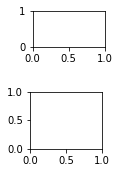

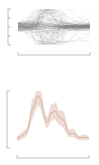

In [73]:
#Orco heading and angvel pltos
layout =fifi.svg_to_axes.FigureLayout(s9_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])

ax = layout.axes[('orco', 'head')]
ax1 = layout.axes[('orco', 'angvel')]

############################################################################

for r in uw_orco['obj_id_unique'].unique():
    t =uw_orco[uw_orco['obj_id_unique']==r]
    x =t['time stamp'].to_numpy()
    y=t['heading'].to_numpy()
    x, y = remove_discontinuities(x, y)
    ax.plot(x, y, color = 'gray', linewidth = .2, alpha =.4)

ax.set_xlim(0, 680)
ax.set_ylim(-3.2, 3.2)
ax.set_yticklabels([])
ax.set_xticklabels([])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, 680], yticks =[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                                                                                     tick_length=3, linewidth=lw)

#Angular Velocity plot
t, m, u, l = slice_means_gs(uw_orco, 'smoothed_angvel_params_128')

ax1.plot(t, m, linewidth = lw, color = 'sienna')
ax1.fill_between(t, u, l, color = 'sienna', alpha = 0.2, label = '', linewidth =0)
ax1.set_xlim(0, 680)
ax1.set_ylim(0, 16)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
fifi.mpl_functions.adjust_spines(ax1, ['left', 'bottom'],xticks=[0, 680], yticks =[0, 16],
                                                                                     tick_length=3, linewidth=lw)
layout.append_figure_to_layer(layout.figures['orco'], 'orco', cleartarget=True)
layout.write_svg(s9_template)

In [75]:
df=etoh

In [78]:
df.course_smooth = wrap_angle(df.course+np.pi)


In [79]:
df_odor = df[df.odor_stimulus=='on']

In [80]:
# first turns only

odors = []

times_uw = []
courses_uw = []

times_cw = []
courses_cw = []

for objid in df_odor.objid.unique():
    #print(objid)
    trajec = df_odor[df_odor.objid==objid]
    chunks, breaks = flymath.get_continuous_chunks(trajec.time_since_odor_onset)
    
    if len(chunks) > 0:
        chunk = None
        b = None
        ix = 0
        while chunk is None:
            if len(chunks[ix]) == 0:
                ix += 1
                continue
                
            if chunks[ix][0] == 0 and len(chunks[ix]) > 10:
                chunk = chunks[ix]
                b = breaks[ix]
                break
            ix += 1
            if ix > len(chunks)-1:
                break
        
        if chunk is not None:
            start = np.max( (0, b-30) )
            end = np.min( (b+200, trajec.shape[0]) )
            odors.append(trajec.iloc[b:end].odor.max())
            #print(b, end, trajec.shape)
            
            if np.mean( np.abs(trajec.iloc[start:end].course_smooth.values[0:30] )) < 30*np.pi/180:
                times_uw.append(trajec.iloc[start:end].time_epoch - trajec.iloc[b:end].time_epoch.values[0])
                courses_uw.append( trajec.iloc[start:end].course_smooth )
                #ax1.plot(trajec.iloc[b:end].time_epoch - trajec.iloc[b:end].time_epoch.values[0], trajec.iloc[b:end].course_smooth)
            #elif np.abs( trajec.iloc[start:end].course_smooth.values[0] ) > 45*np.pi/180 and np.abs( trajec.iloc[start:end].course_smooth.values[0] ) < 135*np.pi/180:
            #    times_cw.append(trajec.iloc[start:end].time_epoch - trajec.iloc[b:end].time_epoch.values[0])
            #    courses_cw.append( trajec.iloc[start:end].course_smooth )
            #    #ax2.plot(trajec.iloc[b:end].time_epoch - trajec.iloc[b:end].time_epoch.values[0], trajec.iloc[b:end].course_smooth)

In [81]:
ethanol_anemometric_turns_first_encounter = {'times_uw': times_uw,
                                             'courses_uw': courses_uw}

In [82]:
# all turns

odors = []

times_uw = []
courses_uw = []

time_since_last_odor = []

times_cw = []
courses_cw = []

for objid in df_odor.objid.unique():
    #print(objid)
    trajec = df_odor[df_odor.objid==objid]
    chunks, breaks = flymath.get_continuous_chunks(trajec.time_since_odor_onset)
    
    if len(chunks) > 0:
        for ix, chunk in enumerate(chunks):
            if len(chunk) > 0 and chunk[0]  == 0:
                b = breaks[ix]
                start = np.max( (0, b-60) )
                end = np.min( (b+200, trajec.shape[0]) )
                odors.append(trajec.iloc[b:end].odor.max())
                #print(b, end, trajec.shape)

                if np.mean( np.abs(trajec.iloc[start:end].course_smooth.values[30:60] )) < 30*np.pi/180:
                    times_uw.append(trajec.iloc[start:end].time_epoch - trajec.iloc[b:end].time_epoch.values[0])
                    courses_uw.append( trajec.iloc[start:end].course_smooth )
                    
                    if ix > 1:
                        time_since_last_odor.append( (b - breaks[ix-1])*0.01 )
                    else:
                        time_since_last_odor.append(np.nan)
                    #ax1.plot(trajec.iloc[b:end].time_epoch - trajec.iloc[b:end].time_epoch.values[0], trajec.iloc[b:end].course_smooth)
                #elif np.abs( trajec.iloc[start:end].course_smooth.values[0] ) > 45*np.pi/180 and np.abs( trajec.iloc[start:end].course_smooth.values[0] ) < 135*np.pi/180:
                #    times_cw.append(trajec.iloc[start:end].time_epoch - trajec.iloc[b:end].time_epoch.values[0])
                #    courses_cw.append( trajec.iloc[start:end].course_smooth )
                #    #ax2.plot(trajec.iloc[b:end].time_epoch - trajec.iloc[b:end].time_epoch.values[0], trajec.iloc[b:end].course_smooth)

In [83]:
ethanol_anemometric_turns_all_encounters = {'times_uw': times_uw,
                                             'courses_uw': courses_uw,
                                            'odors': odors,
                                            'time_since_last_odor': time_since_last_odor}

In [84]:
heads = ethanol_anemometric_turns_all_encounters['courses_uw']
times = ethanol_anemometric_turns_all_encounters['times_uw']

In [85]:
def remove_discontinuities(x, y, jump=2):
    """
    Returns an array with np.nan inserted between all discontinuities (defined by the size of jump), this prevents plotting functions from plotting the connecting line, which looks ugly.
    
    x    -- numpy array (1 dim)
    y    -- numpy array with the discontinuities (1 dim)
    jump -- size of discontinuity to break
    
    """

    pos = np.where(np.abs(np.diff(y)) >= jump)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)
    
    return x, y
    

In [86]:
def unwrap_angle(z, correction_window_for_2pi=100, n_range=2, plot=False):

        
    smooth_zs = np.array(z[0:2])
    for i in range(2, len(z)):
        first_ix = np.max([0, i-correction_window_for_2pi])
        last_ix = i

        nbase = np.round( (smooth_zs[-1] - z[i])/(2*np.pi) )

        candidates = []
        for n in range(-1*n_range, n_range):
            candidates.append(n*2*np.pi+nbase*2*np.pi+z[i])
        error = np.abs(candidates - np.mean(smooth_zs[first_ix:last_ix])) 
        smooth_zs = np.hstack(( smooth_zs, [candidates[np.argmin(error)]] ))
    if plot:
        plt.plot(smooth_zs, '.', color='black', markersize=1)
        
    return smooth_zs

In [87]:
linewidth = 0.4
dt = 0.01
head_pos = []
time_pos = []

head_neg = []
time_neg = []


In [95]:
t0=-1
t_interp = np.arange(t0, 1, 0.01)

head_pos_interp = []
for r in range(len(head_pos)):
    head_interp = np.interp(t_interp, time_pos[r], head_pos[r])
    ix = np.where(t_interp > time_pos[r][-1])
    head_interp[ix] = np.nan
    ix = np.where(t_interp < time_pos[r][0])
    head_interp[ix] = np.nan
    #if len(ix[0]) == 0:
    head_pos_interp.append(head_interp)
    
head_neg_interp = []
for r in range(len(head_neg)):
    head_interp = np.interp(t_interp, time_neg[r], head_neg[r])
    ix = np.where(t_interp > time_neg[r][-1])
    head_interp[ix] = np.nan
    ix = np.where(t_interp < time_neg[r][0])
    head_interp[ix] = np.nan
    #if len(ix[0]) == 0:
    head_neg_interp.append(head_interp)

In [96]:
head_neg_interp = np.vstack( head_neg_interp )

head_pos_interp = np.vstack( head_pos_interp )


In [98]:
t_interp = t_interp.astype(float)

In [99]:
ang_vels = []
ang_vels_u =[]
ang_vels_l=[]
for r in range(len(head_neg_interp)):
    head_vec = head_neg_interp[r]
    ix = np.where( ~np.isnan(head_vec) )
    a = unwrap_angle(head_vec[ix], 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    dafull = np.ones_like(head_vec)*np.nan
    dafull[ix] = da
    ang_vels.append( np.abs(dafull) )
for r in range(len(head_pos_interp)):
    head_vec = head_pos_interp[r]
    ix = np.where( ~np.isnan(head_vec) )
    a = unwrap_angle(head_vec[ix], 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    dafull = np.ones_like(head_vec)*np.nan
    dafull[ix] = da
    ang_vels.append( np.abs(dafull) )

/home/flybot/PyNumDiff_ENV/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


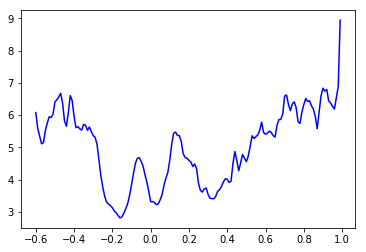

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111)

mean = np.nanmean(np.vstack(ang_vels), axis=0)
ax.plot(t_interp, mean, color='blue')

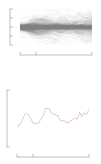

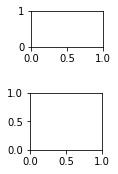

In [101]:
layout =fifi.svg_to_axes.FigureLayout(s9_template, 
                                      autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax = layout.axes[('etoh', 'head')]
ax1 = layout.axes[('etoh', 'angvel')]
############################################################
#Gray head plots
for i in range(len(heads)):

    head_vec = heads[i].values
    time_vec = times[i].values

    a = unwrap_angle(head_vec, 5)
    smootha, da = pynumdiff.linear_model.savgoldiff(a, dt, [3,5,5])
    
    
    ix_plot = np.where( (time_vec>t0)*(time_vec<3) )
    ix_da = np.where( (time_vec>-0.05)*(time_vec<0.2) )[0]
    if np.mean(a[ix_da]) > 0:
        
#         h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
#         h_flipped = []
#         for chunk in range(len(h)):
#             if len(h[chunk]) > 0:
#                 if t[chunk][0] > 0: # if time is after stimulus, consider flipping
#                     if h[chunk][0] < 0:
#                         #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
#                         h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
#                     else:
#                         #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
#                         h_flipped = np.hstack((h_flipped, h[chunk]))
#                 else:
#                     #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
#                     h_flipped = np.hstack((h_flipped, h[chunk]))
        
        
        head_pos.append(head_vec[ix_plot])
        time_pos.append(time_vec[ix_plot])
        x, y =remove_discontinuities(time_vec[ix_plot], head_vec[ix_plot], jump=np.pi/2)
        ax.plot(x, y, color = 'gray', linewidth = lw, alpha =0.1)
    else:
        
#         h, t, breaks = flymath.get_continuous_chunks(head_vec, time_vec, jump=np.pi/2.)
#         h_flipped = []
#         for chunk in range(len(h)):
#             if len(h[chunk]) > 0:
#                 if t[chunk][0] > 0: # if time is after stimulus, consider flipping
#                     if h[chunk][0] > 0:
#                         #ax1.plot( np.array(t[chunk]), -1*np.array(h[chunk]), color = 'gray', linewidth = 1.5, alpha =0.15)
#                         h_flipped = np.hstack((h_flipped, -1*np.array(h[chunk])))
#                     else:
#                         #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
#                         h_flipped = np.hstack((h_flipped, h[chunk]))
#                 else:
#                     #ax1.plot(t[chunk], h[chunk], color = 'gray', linewidth = 1.5, alpha =0.15)
#                     h_flipped = np.hstack((h_flipped, h[chunk]))
                    
        head_neg.append(head_vec[ix_plot])
        time_neg.append(time_vec[ix_plot])
        x, y =remove_discontinuities(time_vec[ix_plot], head_vec[ix_plot], jump=np.pi/2)
        ax.plot(x, y, color = 'gray', linewidth = lw, alpha =0.1)


############################################################
#two peaks in ang vel profile
ax1.plot(t_interp, mean, linewidth = lw, color = 'sienna')


###########################################################
#Axis handling
ax.set_ylim(-3.14, 3.14)
ax.set_xlim(-.15, .53)

ax.set_yticklabels([])
ax.set_xticklabels([])

ax1.set_xlim(-.15, .53)
ax1.set_ylim(0, 8)

ax1.set_yticklabels([])
ax1.set_xticklabels([])
fifi.mpl_functions.adjust_spines(ax1, ['left', 'bottom'],xticks=[-.15,0, .53], yticks =[0, 8],
                                                                                     tick_length=3, linewidth=lw)
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[-.15,0, .53], yticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14],
                                                                                     tick_length=3, linewidth=lw)

layout.append_figure_to_layer(layout.figures['etoh'], 'etoh', cleartarget=True)
layout.write_svg(s9_template)

In [7366]:
def slice_means_time_lumping(df, index, time_key= "time stamp", start=-100, stop=3000, bin_size=10):
    time_vec=[]
    mean_vec=[]
    upper_vec =[]
    lower_vec =[]
    df=df[df[time_key].between(start, stop)]
    temporal_bins=np.arange(start, stop, bin_size)
    #print(temporal_bins)
    for i in temporal_bins:
        dummy_df =df[df[time_key].between(i-bin_size/2, i+bin_size/2)]
        time_vec.append(i)
        
        mean = dummy_df[index].mean()
        upper= dummy_df[index].mean() + dummy_df[index].sem()*1.96
        lower= dummy_df[index].mean() - dummy_df[index].sem()*1.96
        mean_vec.append(mean)
        upper_vec.append(upper)
        lower_vec.append(lower)
    return time_vec, mean_vec, upper_vec, lower_vec